In [ ]:
pwd

In [6]:
import os
os.chdir('f:\\iNeuron\\Projects\\scania_failures_2')
import pandas as pd
import numpy as np
from pprint import pprint
from pathlib import Path

import mlflow
import mlflow.data
from mlflow.client import MlflowClient
import mlflow.pyfunc
client = MlflowClient(tracking_uri = 'https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow',
                      registry_uri = 'https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow')


from src.utils import (load_yaml,save_yaml,save_binary, params_extractor,
                       eval_metrics, parameter_tuning, best_model_finder, 
                       stacking_clf_trainer, voting_clf_trainer, model_trainer, mlflow_logger)
from src.constants import *
from src.utils import load_yaml
from src.components.stage_3_data_split import data_splitting_component
from src.components.stage_4_final_preprocessing import stage_4_final_processing_component
from src.config.configuration_manager import ConfigurationManager
from src.entity.entity_config import (Stage2ProcessingConf,
                                      ModelMetricsConf, 
                                      ModelTrainerConf, 
                                      PreprocessorConf, 
                                      DataSplitConf,
                                      Stage1ProcessingConf)
from src import logger

import optuna

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, 
                              HistGradientBoostingClassifier, StackingClassifier, VotingClassifier)
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.utils import eval_metrics
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer

from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

models = {'Logistic_Regression': LogisticRegression, 
            'SGD_Classifier': SGDClassifier,
            'Random Forest': RandomForestClassifier ,
            'Ada_Boost': AdaBoostClassifier, 
            'Grad_Boost': GradientBoostingClassifier, 
            'Bagging_Classifier': BaggingClassifier, 
            'ExtraTreesClassifier': ExtraTreesClassifier, 
            'Hist_Grad_Boost_Classifier': HistGradientBoostingClassifier, 
            'Decision_Tree_Classifier': DecisionTreeClassifier,
            'XGB_Classifier': XGBClassifier,
            'KNN_Classifier': KNeighborsClassifier,
            'Light_GBM' : LGBMClassifier,
            # 'Stacked_Classifier' : StackingClassifier,
            # 'Voting_Classifier' : VotingClassifier
            }


import pandas as pd
data_path = Path('F:\iNeuron\Projects\scania_failures_2\\artifacts\data\processed\stage_1_processing\preprocessed_train_data.csv')
data = pd.read_csv(data_path)


os.environ['MLFLOW_TRACKING_URI']='https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow'
os.environ['MLFLOW_TRACKING_USERNAME']='Raj-Narayanan-B'
os.environ['MLFLOW_TRACKING_PASSWORD']='8af4cc66be8aec751397fd525e47ae395fa67442'

print(mlflow.get_tracking_uri())
print(mlflow.get_registry_uri())

batch_size = 5000
num_batches = data.shape[0] // batch_size
data_shuffled = shuffle(data, random_state=42)

batch_list = []
# Iterate through batches
for i in range(num_batches):
    # Extract a batch
    start_idx = i * batch_size
    end_idx = ((i + 1) * batch_size)
    # print(f"start_idx: {start_idx}, end_idx: {end_idx}")
    batch_list.append(data_shuffled.iloc[start_idx:end_idx, :])

sum1 = 0
sum0 = 0
for i in range(len(batch_list)):
    print(f"Batch: {i}")
    sum0 += batch_list[i]['class'].value_counts()[0] 
    sum1 += batch_list[i]['class'].value_counts()[1] 
    print(batch_list[i]['class'].value_counts(),'\n')

print(f"Total no of Class 0 in all batches: {sum0}")
print(f"Total no of Class 1 in all batches: {sum1}")

# for working with the entire dataset  
train_data = pd.read_csv('F:\iNeuron\Projects\scania_failures_2\\artifacts\data\processed\stage_2_processing\processed_train_data.csv')
test_data = pd.read_csv('F:\iNeuron\Projects\scania_failures_2\\artifacts\data\processed\stage_2_processing\processed_test_data.csv')

https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow
https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow
Batch: 0
class
0    4913
1      87
Name: count, dtype: int64 

Batch: 1
class
0    4917
1      83
Name: count, dtype: int64 

Batch: 2
class
0    4916
1      84
Name: count, dtype: int64 

Batch: 3
class
0    4916
1      84
Name: count, dtype: int64 

Batch: 4
class
0    4915
1      85
Name: count, dtype: int64 

Batch: 5
class
0    4916
1      84
Name: count, dtype: int64 

Batch: 6
class
0    4910
1      90
Name: count, dtype: int64 

Batch: 7
class
0    4919
1      81
Name: count, dtype: int64 

Batch: 8
class
0    4919
1      81
Name: count, dtype: int64 

Batch: 9
class
0    4919
1      81
Name: count, dtype: int64 

Batch: 10
class
0    4923
1      77
Name: count, dtype: int64 

Batch: 11
class
0    4917
1      83
Name: count, dtype: int64 

Total no of Class 0 in all batches: 59000
Total no of Class 1 in all batches: 1000


In [5]:
# batchwise_accuracies = {}
exp_count = 155
exp_id_list = []
params = load_yaml(PARAMS_PATH)
model_trial_study_df = pd.DataFrame()
accuracies = {}
for keys in models.keys():
    accuracies[keys] = {}
    accuracies[keys]['Optuna'] = []
    accuracies[keys]['HyperOpt'] = []
tags = {"tuner": "optuna",
        "metrics": "['Balanced_Accuracy_Score', 'F1_Score', 'Accuracy_Score', 'Cost']"}
count = 1
for key,value in models.items():
    exp_id = mlflow.create_experiment(name = f"{exp_count}_{key}_{exp_count}", tags = tags)
         
    def optuna_objective(trial,exp_id = exp_id):
        with mlflow.start_run(experiment_id = exp_id,
                          run_name = f"{key}_Trial_{trial.number}",
                          tags = {"tuner" : "optuna",
                                  'trial': f"{trial.number}",
                                  'model' : key,
                                  "run_type": "parent"}) as parent_run:
            parent_run_id = parent_run.info.run_id
            child_id_list = []
            batch_wise_accuracy = []
            space = {}
            flag = 0
            print(f"\n**************\nTrial_Number: {trial.number}\n**************")
            for key_,value_ in params['optuna'][key].items():
                    space[key_] = eval(value_)
            for i in range(len(batch_list)-2):
                x = batch_list[i].drop(columns='class')
                y = batch_list[i]['class']
                print(f"\nBatch {i}")
                # for key,value in models.items():
                        
                pprint(f"\nSpace: {space}",compact=True)
                pipeline = Pipeline(steps = [("KNN_Imputer", KNNImputer()),
                                            ("Robust_Scaler", RobustScaler()),
                                            ("SMOTETomek", SMOTETomek(sampling_strategy = "minority",random_state = 42, n_jobs = -1)),
                                            (f"{key}", value(**space))])
                skf_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
                
                cv_results = cross_validate(estimator=pipeline,
                                        X= x,
                                        y = y,
                                        scoring = 'accuracy',
                                        cv = skf_cv,
                                        n_jobs = -1,
                                        verbose = 2,
                                        return_estimator=True)
                accuracy = cv_results['test_score']
                pipeline = cv_results['estimator'][0]
                estimator = pipeline.named_steps[key]
                print(f"\nAccuracy of {key}: {np.mean(accuracy)}")

                batch_wise_accuracy.append(np.mean(accuracy))
                accuracies[key]['Optuna'].append(np.mean(accuracy))
                print(f"\nBatchwise_accuracies: {batch_wise_accuracy}")         
                print(f"\nBatchwise_Median_Accuracy: {np.median(batch_wise_accuracy)}")         
                print(f"\nAccumulated Accuracies:\n{accuracies}\n")

                trial.report(np.mean(accuracy),i)
                child_run_id = 0
                with mlflow.start_run(experiment_id = exp_id,
                                      run_name = f"Batch_{i}",
                                      tags = {"tuner" : "optuna",
                                              'model' : key,
                                              "run_type": "child"},
                                      nested = True) as child_run:
                            child_run_id = child_run.info.run_id
                            child_id_list.append(child_run_id)
                            # data = (x_train, y_test, y_pred)
                            mlflow_logger(model = estimator,
                                          client = client,                        ## Logs every child runs for successful batches 
                                        model_name = key,
                                        #   params = model.get_params(),
                                        should_log_parent_model = False,
                                        artifact_path = f'{key}_batch_{i}')
                            mlflow.log_metrics(metrics = {"Accuracy_Score": np.mean(accuracy)})
                            dataset_ = mlflow.data.from_pandas(df = batch_list[i],
                                                              targets = 'class',
                                                              name= f"Batch {i}")
                            mlflow.log_input(dataset = dataset_,
                                             context = 'Batchwise Cross-Validation')
                if (i > 5) and (i % 2 == 0):
                    trial.study.set_user_attr('median_accuracy',np.median(batch_wise_accuracy))
                    if np.mean(accuracy) < np.median(batch_wise_accuracy):
                        flag = 1
                        break
            if flag == 0:
                mlflow_logger(model_name = key,
                          should_log_parent_model = True,
                          client = client,
                          metrics_ =  {"Accuracy_Score":max(batch_wise_accuracy)},
                          run_id = parent_run_id,
                          exp_id = exp_id,
                          #   registered_model_name = f"Challenger_Optuna_{model_name}",
                          artifact_path = f'challenger_{key}')
        if flag == 1:
            mlflow.delete_run(run_id = parent_run_id)
            try:
                 for child_run in child_id_list:
                      mlflow.delete_run(child_run)
            except:
                 pass

            raise optuna.TrialPruned()

        return np.mean(batch_wise_accuracy)
    find_params = optuna.create_study(direction = 'maximize',pruner=optuna.pruners.MedianPruner(),sampler = optuna.samplers.TPESampler(constant_liar=True))
    find_params.optimize(func = optuna_objective,
                         n_trials = 3)
    if count == 1:
        model_trial_study_df = find_params.trials_dataframe()
        model_trial_study_df['Model_name'] = key
        count += 1
    else:
        temp_df = find_params.trials_dataframe()
        temp_df['Model_name'] = key
        model_trial_study_df = pd.concat([model_trial_study_df, temp_df])
    model_trial_study_df.to_csv('artifacts/metrics/model_trial_study_df.csv', index = False)
    
    mlflow_df = mlflow.search_runs(experiment_ids=[f'{exp_id}'])
    if mlflow_df.empty:
         pass
    else:
        mlflow_logger(client = client,
                    model_name = key,
                    exp_id = exp_id,
                    registered_model_name = f"Challenger_{key}",
                    artifact_path = None)
        exp_id_list.append(exp_id)

[2024-01-31 07:41:08,419: INFO: utils: params.yaml yaml_file is loaded]


[I 2024-01-31 07:41:08,837] A new study created in memory with name: no-name-bee2418f-4771-4ab3-8857-0d044123b101



**************
Trial_Number: 0
**************

Batch 0
"\nSpace: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'log2'}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.8s finished



Accuracy of Decision_Tree_Classifier: 0.972000557871619

Batchwise_accuracies: [0.972000557871619]

Batchwise_Median_Accuracy: 0.972000557871619

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 1
"\nSpace: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'log2'}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.7s finished



Accuracy of Decision_Tree_Classifier: 0.970400637759603

Batchwise_accuracies: [0.972000557871619, 0.970400637759603]

Batchwise_Median_Accuracy: 0.971200597815611

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 2
"\nSpace: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'log2'}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.1s finished



Accuracy of Decision_Tree_Classifier: 0.9766004782236829

Batchwise_accuracies: [0.972000557871619, 0.970400637759603, 0.9766004782236829]

Batchwise_Median_Accuracy: 0.972000557871619

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 3
"\nSpace: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'log2'}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.8s finished



Accuracy of Decision_Tree_Classifier: 0.9753995179355486

Batchwise_accuracies: [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486]

Batchwise_Median_Accuracy: 0.9737000379035838

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 4
"\nSpace: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'log2'}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.0s finished



Accuracy of Decision_Tree_Classifier: 0.9763997980715983

Batchwise_accuracies: [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983]

Batchwise_Median_Accuracy: 0.9753995179355486

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 5
"\nSpace: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'log2'}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.8s finished



Accuracy of Decision_Tree_Classifier: 0.9698003976635645

Batchwise_accuracies: [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645]

Batchwise_Median_Accuracy: 0.9737000379035838

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 6
"\nSpace: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'log2'}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.1s finished



Accuracy of Decision_Tree_Classifier: 0.9727983574953676

Batchwise_accuracies: [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676]

Batchwise_Median_Accuracy: 0.9727983574953676

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 7
"\nSpace: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'log2'}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s finished



Accuracy of Decision_Tree_Classifier: 0.9761998380635998

Batchwise_accuracies: [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998]

Batchwise_Median_Accuracy: 0.9740989377154581

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 8
"\nSpace: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'log2'}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.2s finished



Accuracy of Decision_Tree_Classifier: 0.9763996780475838

Batchwise_accuracies: [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838]

Batchwise_Median_Accuracy: 0.9753995179355486

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 9
"\nSpace: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'log2'}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.0s finished



Accuracy of Decision_Tree_Classifier: 0.9722006379036318

Batchwise_accuracies: [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318]

Batchwise_Median_Accuracy: 0.9740989377154581

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model
Logging Parent Model
Experiment IDs:  367
Parent_Run_ID: 450efe8500494c1a96b4d1b365adf12d
Artifact_Path: mlflow-artifacts:/45286f1704274a2c97b1a625f6b97ac2/3c9a6db9c7094dfb94995083e100ee4e/artifacts/Decision_Tree_C

Best Params:
 {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_features': 'log2', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'} 



[I 2024-01-31 07:45:52,525] Trial 0 finished with value: 0.9738199899035799 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'log2'}. Best is trial 0 with value: 0.9738199899035799.



**************
Trial_Number: 1
**************

Batch 0
('\n'
 "Space: {'criterion': 'log_loss', 'splitter': 'random', 'max_features': "
 "'log2'}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.7s finished



Accuracy of Decision_Tree_Classifier: 0.9600001968393835

Batchwise_accuracies: [0.9600001968393835]

Batchwise_Median_Accuracy: 0.9600001968393835

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 1
('\n'
 "Space: {'criterion': 'log_loss', 'splitter': 'random', 'max_features': "
 "'log2'}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.0s finished



Accuracy of Decision_Tree_Classifier: 0.9714011579436814

Batchwise_accuracies: [0.9600001968393835, 0.9714011579436814]

Batchwise_Median_Accuracy: 0.9657006773915324

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 2
('\n'
 "Space: {'criterion': 'log_loss', 'splitter': 'random', 'max_features': "
 "'log2'}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.2s finished



Accuracy of Decision_Tree_Classifier: 0.9765997580795966

Batchwise_accuracies: [0.9600001968393835, 0.9714011579436814, 0.9765997580795966]

Batchwise_Median_Accuracy: 0.9714011579436814

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 3
('\n'
 "Space: {'criterion': 'log_loss', 'splitter': 'random', 'max_features': "
 "'log2'}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.8s finished



Accuracy of Decision_Tree_Classifier: 0.9666001973674893

Batchwise_accuracies: [0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893]

Batchwise_Median_Accuracy: 0.9690006776555853

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 4
('\n'
 "Space: {'criterion': 'log_loss', 'splitter': 'random', 'max_features': "
 "'log2'}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.2s finished



Accuracy of Decision_Tree_Classifier: 0.9624012772475515

Batchwise_accuracies: [0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515]

Batchwise_Median_Accuracy: 0.9666001973674893

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 5
('\n'
 "Space: {'criterion': 'log_loss', 'splitter': 'random', 'max_features': "
 "'log2'}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.2s finished



Accuracy of Decision_Tree_Classifier: 0.9651992770713566

Batchwise_accuracies: [0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566]

Batchwise_Median_Accuracy: 0.9658997372194229

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 6
('\n'
 "Space: {'criterion': 'log_loss', 'splitter': 'random', 'max_features': "
 "'log2'}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.5s finished



Accuracy of Decision_Tree_Classifier: 0.9723992776474718

Batchwise_accuracies: [0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718]

Batchwise_Median_Accuracy: 0.9666001973674893

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Batch 7
('\n'
 "Space: {'criterion': 'log_loss', 'splitter': 'random', 'max_features': "
 "'log2'}")


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.9s finished



Accuracy of Decision_Tree_Classifier: 0.9746000379755982

Batchwise_accuracies: [0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982]

Batchwise_Median_Accuracy: 0.9690006776555853

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 8
('\n'
 "Space: {'criterion': 'log_loss', 'splitter': 'random', 'max_features': "
 "

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s finished



Accuracy of Decision_Tree_Classifier: 0.9706005977676013

Batchwise_accuracies: [0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013]

Batchwise_Median_Accuracy: 0.9706005977676013

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 9
('\n'
 "Space: {'criterion': 'log_loss', 's

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.0s finished



Accuracy of Decision_Tree_Classifier: 0.9702013978956909

Batchwise_accuracies: [0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909]

Batchwise_Median_Accuracy: 0.9704009978316461

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model
Logging Pare

[2024-01-31 07:50:13,417: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow-artifacts/artifacts/45286f1704274a2c97b1a625f6b97ac2/1ff4ea5d39c84583b9449403e205162b/artifacts/Decision_Tree_Classifier_batch_2/MLmodel]
[2024-01-31 07:50:13,438: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow-artifacts/artifacts/45286f1704274a2c97b1a625f6b97ac2/1ff4ea5d39c84583b9449403e205162b/artifacts/Decision_Tree_Classifier_batch_2/requirements.txt]
[2024-01-31 07:50:13,448: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'Remot

Best Params:
 {'ccp_alpha': 0.0, 'criterion': 'log_loss', 'max_features': 'log2', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'} 



[I 2024-01-31 07:50:25,998] Trial 1 finished with value: 0.9690003175835422 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_features': 'log2'}. Best is trial 0 with value: 0.9738199899035799.



**************
Trial_Number: 2
**************

Batch 0
"\nSpace: {'criterion': 'gini', 'splitter': 'random', 'max_features': None}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.8s finished



Accuracy of Decision_Tree_Classifier: 0.9647987569352875

Batchwise_accuracies: [0.9647987569352875]

Batchwise_Median_Accuracy: 0.9647987569352875

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 1
"\nSpace: {'criterion': 'gini', 'splitter': 'random', 'max_features': None}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.0s finished



Accuracy of Decision_Tree_Classifier: 0.9742008381036878

Batchwise_accuracies: [0.9647987569352875, 0.9742008381036878]

Batchwise_Median_Accuracy: 0.9694997975194877

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 2
"\nSpace: {'criterion': 'gini', 'splitter': 'random', 'max_features': None}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.4s finished



Accuracy of Decision_Tree_Classifier: 0.975799918047603

Batchwise_accuracies: [0.9647987569352875, 0.9742008381036878, 0.975799918047603]

Batchwise_Median_Accuracy: 0.9742008381036878

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 3
"\nSpace: {'criterion': 'gini', 'splitter': 'random', 'max_features': None}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s finished



Accuracy of Decision_Tree_Classifier: 0.9691995574474541

Batchwise_accuracies: [0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541]

Batchwise_Median_Accuracy: 0.971700197775571

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 4
"\nSpace: {'criterion': 'gini', 'splitter': 'r

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s finished



Accuracy of Decision_Tree_Classifier: 0.9720009179436623

Batchwise_accuracies: [0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623]

Batchwise_Median_Accuracy: 0.9720009179436623

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and child model

Batch 5
"\nSp

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.6s finished



Accuracy of Decision_Tree_Classifier: 0.9671977969352108

Batchwise_accuracies: [0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108]

Batchwise_Median_Accuracy: 0.9706002376955583

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Loggi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.9s finished



Accuracy of Decision_Tree_Classifier: 0.9741984376233996

Batchwise_accuracies: [0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996]

Batchwise_Median_Accuracy: 0.9720009179436623

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.6s finished



Accuracy of Decision_Tree_Classifier: 0.977599678143603

Batchwise_accuracies: [0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603]

Batchwise_Median_Accuracy: 0.973099677783531

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'HyperOpt': []}, 'KNN_Classifier': {'Optun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s finished



Accuracy of Decision_Tree_Classifier: 0.977200838343736

Batchwise_accuracies: [0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736]

Batchwise_Median_Accuracy: 0.9741984376233996

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [], 'Hy

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s finished



Accuracy of Decision_Tree_Classifier: 0.9749993578715229

Batchwise_accuracies: [0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229]

Batchwise_Median_Accuracy: 0.9741996378635438

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': 

[2024-01-31 07:54:14,775: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow-artifacts/artifacts/45286f1704274a2c97b1a625f6b97ac2/79cd83b00ecc4fee8645ad26fe7af225/artifacts/Decision_Tree_Classifier_batch_7/model.pkl]
[2024-01-31 07:54:14,792: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow-artifacts/artifacts/45286f1704274a2c97b1a625f6b97ac2/79cd83b00ecc4fee8645ad26fe7af225/artifacts/Decision_Tree_Classifier_batch_7/MLmodel]
[2024-01-31 07:54:14,804: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDiscon

Best Params:
 {'ccp_alpha': 0.0, 'criterion': 'gini', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'} 



[I 2024-01-31 07:54:26,239] Trial 2 finished with value: 0.9727196097395167 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_features': None}. Best is trial 0 with value: 0.9738199899035799.


Registering Best Parent Model as Challenger
Client_Tracking_URI:  https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow
Client_Registry_URI:  https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow

Best_Run_ID: d574e78c7c0c420ebf982c91349ff6ab
Best_Model's_Artifact_Path: mlflow-artifacts:/45286f1704274a2c97b1a625f6b97ac2/d574e78c7c0c420ebf982c91349ff6ab/artifacts/challenger_Decision_Tree_Classifier


2024/01/31 07:54:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Challenger_Decision_Tree_Classifier, version 1
[I 2024-01-31 07:54:30,463] A new study created in memory with name: no-name-6a534305-d632-40cd-9154-fb271d5b3852



**************
Trial_Number: 0
**************

Batch 0
('\n'
 "Space: {'n_estimators': 289, 'learning_rate': 0.5403250465554214, 'booster': "
 "'gbtree', 'tree_method': 'approx'}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.4s finished



Accuracy of XGB_Classifier: 0.9837992785596542

Batchwise_accuracies: [0.9837992785596542]

Batchwise_Median_Accuracy: 0.9837992785596542

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': [], 'HyperOpt': []}}

Logging params and

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.4s finished



Accuracy of XGB_Classifier: 0.9836001587197566

Batchwise_accuracies: [0.9837992785596542, 0.9836001587197566]

Batchwise_Median_Accuracy: 0.9836997186397054

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], 'HyperOpt': []}, 'Light_GBM': {'Optuna': 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.9s finished



Accuracy of XGB_Classifier: 0.9853997987917422

Batchwise_accuracies: [0.9837992785596542, 0.9836001587197566, 0.9853997987917422]

Batchwise_Median_Accuracy: 0.9837992785596542

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422], 'HyperOpt': []}, 'KNN_Classifier': {'Optuna': [], '

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Batch 3
('\n'
 "Space: {'n_estimators': 289, 'learning_rate': 0.5403250465554214, 'booster': "
 "'gbtree', 'tree_method': 'approx'}")


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.2s finished



Accuracy of XGB_Classifier: 0.9855996387757262

Batchwise_accuracies: [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262]

Batchwise_Median_Accuracy: 0.9845995386756983

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262], 'HyperOpt':

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.9s finished



Accuracy of XGB_Classifier: 0.9869998389277725

Batchwise_accuracies: [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725]

Batchwise_Median_Accuracy: 0.9853997987917422

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.5s finished



Accuracy of XGB_Classifier: 0.9838004787997982

Batchwise_accuracies: [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982]

Batchwise_Median_Accuracy: 0.9846001387957701

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.9s finished



Accuracy of XGB_Classifier: 0.9873995188957406

Batchwise_accuracies: [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.9873995188957406]

Batchwise_Median_Accuracy: 0.9853997987917422

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.3s finished



Accuracy of XGB_Classifier: 0.9878003991038526

Batchwise_accuracies: [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.9873995188957406, 0.9878003991038526]

Batchwise_Median_Accuracy: 0.9854997187837342

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.2s finished



Accuracy of XGB_Classifier: 0.9832009588478462

Batchwise_accuracies: [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.9873995188957406, 0.9878003991038526, 0.9832009588478462]

Batchwise_Median_Accuracy: 0.9853997987917422

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Op

[I 2024-01-31 08:00:33,186] Trial 0 pruned. 



**************
Trial_Number: 1
**************

Batch 0
('\n'
 "Space: {'n_estimators': 114, 'learning_rate': 0.9331549344828524, 'booster': "
 "'gbtree', 'tree_method': 'exact'}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.1s finished



Accuracy of XGB_Classifier: 0.9839994786156815

Batchwise_accuracies: [0.9839994786156815]

Batchwise_Median_Accuracy: 0.9839994786156815

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.9873995188957406, 0.9878003991

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.7s finished



Accuracy of XGB_Classifier: 0.9807999984636927

Batchwise_accuracies: [0.9839994786156815, 0.9807999984636927]

Batchwise_Median_Accuracy: 0.9823997385396871

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.9873995188

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.4s finished



Accuracy of XGB_Classifier: 0.985399438719699

Batchwise_accuracies: [0.9839994786156815, 0.9807999984636927, 0.985399438719699]

Batchwise_Median_Accuracy: 0.9839994786156815

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.983800478799

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.0s finished



Accuracy of XGB_Classifier: 0.984799918767747

Batchwise_accuracies: [0.9839994786156815, 0.9807999984636927, 0.985399438719699, 0.984799918767747]

Batchwise_Median_Accuracy: 0.9843996986917143

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.4s finished



Accuracy of XGB_Classifier: 0.9871996789117566

Batchwise_accuracies: [0.9839994786156815, 0.9807999984636927, 0.985399438719699, 0.984799918767747, 0.9871996789117566]

Batchwise_Median_Accuracy: 0.984799918767747

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.5s finished



Accuracy of XGB_Classifier: 0.9832005987758029

Batchwise_accuracies: [0.9839994786156815, 0.9807999984636927, 0.985399438719699, 0.984799918767747, 0.9871996789117566, 0.9832005987758029]

Batchwise_Median_Accuracy: 0.9843996986917143

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.985399798791

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.2s finished



Accuracy of XGB_Classifier: 0.9865995588397326

Batchwise_accuracies: [0.9839994786156815, 0.9807999984636927, 0.985399438719699, 0.984799918767747, 0.9871996789117566, 0.9832005987758029, 0.9865995588397326]

Batchwise_Median_Accuracy: 0.984799918767747

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.1s finished



Accuracy of XGB_Classifier: 0.9868001189678032

Batchwise_accuracies: [0.9839994786156815, 0.9807999984636927, 0.985399438719699, 0.984799918767747, 0.9871996789117566, 0.9832005987758029, 0.9865995588397326, 0.9868001189678032]

Batchwise_Median_Accuracy: 0.985099678743723

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.3s finished



Accuracy of XGB_Classifier: 0.9832005987758029

Batchwise_accuracies: [0.9839994786156815, 0.9807999984636927, 0.985399438719699, 0.984799918767747, 0.9871996789117566, 0.9832005987758029, 0.9865995588397326, 0.9868001189678032, 0.9832005987758029]

Batchwise_Median_Accuracy: 0.984799918767747

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optun

[I 2024-01-31 08:05:01,070] Trial 1 pruned. 



**************
Trial_Number: 2
**************

Batch 0
('\n'
 "Space: {'n_estimators': 401, 'learning_rate': 0.6951656730630655, 'booster': "
 "'dart', 'tree_method': 'exact'}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.1s finished



Accuracy of XGB_Classifier: 0.9839991185436382

Batchwise_accuracies: [0.9839991185436382]

Batchwise_Median_Accuracy: 0.9839991185436382

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.9873995188957406, 0.9878003991

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.8s finished



Accuracy of XGB_Classifier: 0.9827999586157198

Batchwise_accuracies: [0.9839991185436382, 0.9827999586157198]

Batchwise_Median_Accuracy: 0.983399538579679

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.98739951889

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.5s finished



Accuracy of XGB_Classifier: 0.9845995986877054

Batchwise_accuracies: [0.9839991185436382, 0.9827999586157198, 0.9845995986877054]

Batchwise_Median_Accuracy: 0.9839991185436382

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.9s finished



Accuracy of XGB_Classifier: 0.9859994387677086

Batchwise_accuracies: [0.9839991185436382, 0.9827999586157198, 0.9845995986877054, 0.9859994387677086]

Batchwise_Median_Accuracy: 0.9842993586156719

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.7s finished



Accuracy of XGB_Classifier: 0.9863998388797631

Batchwise_accuracies: [0.9839991185436382, 0.9827999586157198, 0.9845995986877054, 0.9859994387677086, 0.9863998388797631]

Batchwise_Median_Accuracy: 0.9845995986877054

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.2s finished



Accuracy of XGB_Classifier: 0.9828005587357919

Batchwise_accuracies: [0.9839991185436382, 0.9827999586157198, 0.9845995986877054, 0.9859994387677086, 0.9863998388797631, 0.9828005587357919]

Batchwise_Median_Accuracy: 0.9842993586156719

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.5s finished



Accuracy of XGB_Classifier: 0.986399238759691

Batchwise_accuracies: [0.9839991185436382, 0.9827999586157198, 0.9845995986877054, 0.9859994387677086, 0.9863998388797631, 0.9828005587357919, 0.986399238759691]

Batchwise_Median_Accuracy: 0.9845995986877054

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.983600158719

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.9s finished



Accuracy of XGB_Classifier: 0.9865999189117759

Batchwise_accuracies: [0.9839991185436382, 0.9827999586157198, 0.9845995986877054, 0.9859994387677086, 0.9863998388797631, 0.9828005587357919, 0.986399238759691, 0.9865999189117759]

Batchwise_Median_Accuracy: 0.9852995187277069

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.98379927855

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.8s finished



Accuracy of XGB_Classifier: 0.983800958895856

Batchwise_accuracies: [0.9839991185436382, 0.9827999586157198, 0.9845995986877054, 0.9859994387677086, 0.9863998388797631, 0.9828005587357919, 0.986399238759691, 0.9865999189117759, 0.983800958895856]

Batchwise_Median_Accuracy: 0.9845995986877054

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optun

[I 2024-01-31 08:10:56,203] Trial 2 pruned. 
[I 2024-01-31 08:10:57,769] A new study created in memory with name: no-name-b72cab78-131c-4530-a95e-a6440ceffd83



**************
Trial_Number: 0
**************

Batch 0
"\nSpace: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'brute'}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.4s finished



Accuracy of KNN_Classifier: 0.9307983541346952

Batchwise_accuracies: [0.9307983541346952]

Batchwise_Median_Accuracy: 0.9307983541346952

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.9873995188957406, 0.9878003991

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.4s finished



Accuracy of KNN_Classifier: 0.9429984351269001

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001]

Batchwise_Median_Accuracy: 0.9368983946307976

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.9873995188

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.6s finished



Accuracy of KNN_Classifier: 0.9375989147908714

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714]

Batchwise_Median_Accuracy: 0.9375989147908714

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.7s finished



Accuracy of KNN_Classifier: 0.9427995553350313

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714, 0.9427995553350313]

Batchwise_Median_Accuracy: 0.9401992350629513

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s finished



Accuracy of KNN_Classifier: 0.9473977953508937

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714, 0.9427995553350313, 0.9473977953508937]

Batchwise_Median_Accuracy: 0.9427995553350313

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.0s finished



Accuracy of KNN_Classifier: 0.9524000361992427

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714, 0.9427995553350313, 0.9473977953508937, 0.9524000361992427]

Batchwise_Median_Accuracy: 0.9428989952309657

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.5s finished



Accuracy of KNN_Classifier: 0.9577997965833004

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714, 0.9427995553350313, 0.9473977953508937, 0.9524000361992427, 0.9577997965833004]

Batchwise_Median_Accuracy: 0.9429984351269001

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.6s finished



Accuracy of KNN_Classifier: 0.9413977948707978

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714, 0.9427995553350313, 0.9473977953508937, 0.9524000361992427, 0.9577997965833004, 0.9413977948707978]

Batchwise_Median_Accuracy: 0.9428989952309657

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.8s finished



Accuracy of KNN_Classifier: 0.9552001964553067

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714, 0.9427995553350313, 0.9473977953508937, 0.9524000361992427, 0.9577997965833004, 0.9413977948707978, 0.9552001964553067]

Batchwise_Median_Accuracy: 0.9429984351269001

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Op

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s finished



Accuracy of KNN_Classifier: 0.9412028758714044

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714, 0.9427995553350313, 0.9473977953508937, 0.9524000361992427, 0.9577997965833004, 0.9413977948707978, 0.9552001964553067, 0.9412028758714044]

Batchwise_Median_Accuracy: 0.9428989952309657

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'X

[2024-01-31 08:16:03,837: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow-artifacts/artifacts/ce67e0b8da12439b9ecd135689264d53/36c49495fc0d4d11b184a7b8d549dff5/artifacts/KNN_Classifier_batch_6/model.pkl]
[2024-01-31 08:16:03,862: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow-artifacts/artifacts/ce67e0b8da12439b9ecd135689264d53/36c49495fc0d4d11b184a7b8d549dff5/artifacts/KNN_Classifier_batch_6/python_env.yaml]
[2024-01-31 08:16:03,880: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remo

Best Params:
 {'algorithm': 'brute', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'} 



[I 2024-01-31 08:16:20,303] Trial 0 finished with value: 0.9449593754718444 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'brute'}. Best is trial 0 with value: 0.9449593754718444.



**************
Trial_Number: 1
**************

Batch 0
"\nSpace: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'auto'}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.5s finished



Accuracy of KNN_Classifier: 0.9447987953429723

Batchwise_accuracies: [0.9447987953429723]

Batchwise_Median_Accuracy: 0.9447987953429723

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.9873995188957406, 0.9878003991

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.0s finished



Accuracy of KNN_Classifier: 0.954599236215182

Batchwise_accuracies: [0.9447987953429723, 0.954599236215182]

Batchwise_Median_Accuracy: 0.9496990157790771

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.987399518895

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s finished



Accuracy of KNN_Classifier: 0.9533988760471196

Batchwise_accuracies: [0.9447987953429723, 0.954599236215182, 0.9533988760471196]

Batchwise_Median_Accuracy: 0.9533988760471196

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.98380047879

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.6s finished



Accuracy of KNN_Classifier: 0.9517999161272188

Batchwise_accuracies: [0.9447987953429723, 0.954599236215182, 0.9533988760471196, 0.9517999161272188]

Batchwise_Median_Accuracy: 0.9525993960871693

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.98699983892

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s finished



Accuracy of KNN_Classifier: 0.9565985962471372

Batchwise_accuracies: [0.9447987953429723, 0.954599236215182, 0.9533988760471196, 0.9517999161272188, 0.9565985962471372]

Batchwise_Median_Accuracy: 0.9533988760471196

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.98559963877

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.2s finished



Accuracy of KNN_Classifier: 0.9619997969193675

Batchwise_accuracies: [0.9447987953429723, 0.954599236215182, 0.9533988760471196, 0.9517999161272188, 0.9565985962471372, 0.9619997969193675]

Batchwise_Median_Accuracy: 0.9539990561311508

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.98539979879

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s finished



Accuracy of KNN_Classifier: 0.9649988369673004

Batchwise_accuracies: [0.9447987953429723, 0.954599236215182, 0.9533988760471196, 0.9517999161272188, 0.9565985962471372, 0.9619997969193675, 0.9649988369673004]

Batchwise_Median_Accuracy: 0.954599236215182

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.983600158719

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.2s finished



Accuracy of KNN_Classifier: 0.9513983157750202

Batchwise_accuracies: [0.9447987953429723, 0.954599236215182, 0.9533988760471196, 0.9517999161272188, 0.9565985962471372, 0.9619997969193675, 0.9649988369673004, 0.9513983157750202]

Batchwise_Median_Accuracy: 0.9539990561311508

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.98379927855

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.6s finished



Accuracy of KNN_Classifier: 0.9639999971194236

Batchwise_accuracies: [0.9447987953429723, 0.954599236215182, 0.9533988760471196, 0.9517999161272188, 0.9565985962471372, 0.9619997969193675, 0.9649988369673004, 0.9513983157750202, 0.9639999971194236]

Batchwise_Median_Accuracy: 0.954599236215182

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optu

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.0s finished



Accuracy of KNN_Classifier: 0.952402436679531

Batchwise_accuracies: [0.9447987953429723, 0.954599236215182, 0.9533988760471196, 0.9517999161272188, 0.9565985962471372, 0.9619997969193675, 0.9649988369673004, 0.9513983157750202, 0.9639999971194236, 0.952402436679531]

Batchwise_Median_Accuracy: 0.9539990561311508

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_

[2024-01-31 08:21:20,571: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow-artifacts/artifacts/ce67e0b8da12439b9ecd135689264d53/2cecf90b33a2474eb378682f531282ae/artifacts/KNN_Classifier_batch_6/MLmodel]
[2024-01-31 08:21:20,585: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow-artifacts/artifacts/ce67e0b8da12439b9ecd135689264d53/2cecf90b33a2474eb378682f531282ae/artifacts/KNN_Classifier_batch_6/python_env.yaml]
[2024-01-31 08:21:20,627: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote

Best Params:
 {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'} 



[I 2024-01-31 08:21:35,162] Trial 1 finished with value: 0.9555994803440273 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'auto'}. Best is trial 1 with value: 0.9555994803440273.



**************
Trial_Number: 2
**************

Batch 0
"\nSpace: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'brute'}"


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.6s finished



Accuracy of KNN_Classifier: 0.9307983541346952

Batchwise_accuracies: [0.9307983541346952]

Batchwise_Median_Accuracy: 0.9307983541346952

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.9873995188957406, 0.9878003991

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.2s finished



Accuracy of KNN_Classifier: 0.9429984351269001

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001]

Batchwise_Median_Accuracy: 0.9368983946307976

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.9873995188

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.9s finished



Accuracy of KNN_Classifier: 0.9375989147908714

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714]

Batchwise_Median_Accuracy: 0.9375989147908714

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.6s finished



Accuracy of KNN_Classifier: 0.9427995553350313

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714, 0.9427995553350313]

Batchwise_Median_Accuracy: 0.9401992350629513

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.5s finished



Accuracy of KNN_Classifier: 0.9473977953508937

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714, 0.9427995553350313, 0.9473977953508937]

Batchwise_Median_Accuracy: 0.9427995553350313

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s finished



Accuracy of KNN_Classifier: 0.9524000361992427

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714, 0.9427995553350313, 0.9473977953508937, 0.9524000361992427]

Batchwise_Median_Accuracy: 0.9428989952309657

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.5s finished



Accuracy of KNN_Classifier: 0.9577997965833004

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714, 0.9427995553350313, 0.9473977953508937, 0.9524000361992427, 0.9577997965833004]

Batchwise_Median_Accuracy: 0.9429984351269001

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.1s finished



Accuracy of KNN_Classifier: 0.9413977948707978

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714, 0.9427995553350313, 0.9473977953508937, 0.9524000361992427, 0.9577997965833004, 0.9413977948707978]

Batchwise_Median_Accuracy: 0.9428989952309657

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s finished



Accuracy of KNN_Classifier: 0.9552001964553067

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714, 0.9427995553350313, 0.9473977953508937, 0.9524000361992427, 0.9577997965833004, 0.9413977948707978, 0.9552001964553067]

Batchwise_Median_Accuracy: 0.9429984351269001

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Op

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.7s finished



Accuracy of KNN_Classifier: 0.9412028758714044

Batchwise_accuracies: [0.9307983541346952, 0.9429984351269001, 0.9375989147908714, 0.9427995553350313, 0.9473977953508937, 0.9524000361992427, 0.9577997965833004, 0.9413977948707978, 0.9552001964553067, 0.9412028758714044]

Batchwise_Median_Accuracy: 0.9428989952309657

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'X

[2024-01-31 08:26:28,590: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow-artifacts/artifacts/ce67e0b8da12439b9ecd135689264d53/833a0a115eac4847a9bb4db6e0121206/artifacts/KNN_Classifier_batch_6/MLmodel]
[2024-01-31 08:26:28,596: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow-artifacts/artifacts/ce67e0b8da12439b9ecd135689264d53/833a0a115eac4847a9bb4db6e0121206/artifacts/KNN_Classifier_batch_6/model.pkl]
[2024-01-31 08:26:28,611: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end c

Best Params:
 {'algorithm': 'brute', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'} 



[I 2024-01-31 08:26:45,061] Trial 2 finished with value: 0.9449593754718444 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'brute'}. Best is trial 1 with value: 0.9555994803440273.


Registering Best Parent Model as Challenger
Client_Tracking_URI:  https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow
Client_Registry_URI:  https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow

Best_Run_ID: e85991c6c1be41b59b3edcb31ac08c61
Best_Model's_Artifact_Path: mlflow-artifacts:/ce67e0b8da12439b9ecd135689264d53/e85991c6c1be41b59b3edcb31ac08c61/artifacts/challenger_KNN_Classifier


2024/01/31 08:26:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Challenger_KNN_Classifier, version 1
[I 2024-01-31 08:26:48,697] A new study created in memory with name: no-name-ffd7908f-a041-4d9c-a88c-bd7820a60a99



**************
Trial_Number: 0
**************

Batch 0
('\n'
 "Space: {'boosting_type': 'gbdt', 'learning_rate': 0.7595521352826132, "
 "'n_estimators': 148, 'class_weight': 'balanced', 'n_jobs': -1}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.8s finished



Accuracy of Light_GBM: 0.9837997586557119

Batchwise_accuracies: [0.9837997586557119]

Batchwise_Median_Accuracy: 0.9837997586557119

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.9873995188957406, 0.987800399103852

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s finished



Accuracy of Light_GBM: 0.9850005989198319

Batchwise_accuracies: [0.9837997586557119, 0.9850005989198319]

Batchwise_Median_Accuracy: 0.9844001787877719

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.987399518895740

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s finished



Accuracy of Light_GBM: 0.9880002390878367

Batchwise_accuracies: [0.9837997586557119, 0.9850005989198319, 0.9880002390878367]

Batchwise_Median_Accuracy: 0.9850005989198319

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.983800478799798

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s finished



Accuracy of Light_GBM: 0.9871996789117566

Batchwise_accuracies: [0.9837997586557119, 0.9850005989198319, 0.9880002390878367, 0.9871996789117566]

Batchwise_Median_Accuracy: 0.9861001389157943

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.986999838927772

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s finished



Accuracy of Light_GBM: 0.9881998390237919

Batchwise_accuracies: [0.9837997586557119, 0.9850005989198319, 0.9880002390878367, 0.9871996789117566, 0.9881998390237919]

Batchwise_Median_Accuracy: 0.9871996789117566

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.985599638775726

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s finished



Accuracy of Light_GBM: 0.9866000389357903

Batchwise_accuracies: [0.9837997586557119, 0.9850005989198319, 0.9880002390878367, 0.9871996789117566, 0.9881998390237919, 0.9866000389357903]

Batchwise_Median_Accuracy: 0.9868998589237734

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.985399798791742

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.5s finished



Accuracy of Light_GBM: 0.9879995189437504

Batchwise_accuracies: [0.9837997586557119, 0.9850005989198319, 0.9880002390878367, 0.9871996789117566, 0.9881998390237919, 0.9866000389357903, 0.9879995189437504]

Batchwise_Median_Accuracy: 0.9871996789117566

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.983600158719756

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s finished



Accuracy of Light_GBM: 0.9865999189117759

Batchwise_accuracies: [0.9837997586557119, 0.9850005989198319, 0.9880002390878367, 0.9871996789117566, 0.9881998390237919, 0.9866000389357903, 0.9879995189437504, 0.9865999189117759]

Batchwise_Median_Accuracy: 0.9868998589237734

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.983799278559654

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.4s finished



Accuracy of Light_GBM: 0.9850007189438462

Batchwise_accuracies: [0.9837997586557119, 0.9850005989198319, 0.9880002390878367, 0.9871996789117566, 0.9881998390237919, 0.9866000389357903, 0.9879995189437504, 0.9865999189117759, 0.9850007189438462]

Batchwise_Median_Accuracy: 0.9866000389357903

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna'

[I 2024-01-31 08:30:03,807] Trial 0 pruned. 



**************
Trial_Number: 1
**************

Batch 0
('\n'
 "Space: {'boosting_type': 'dart', 'learning_rate': 0.18130866415578073, "
 "'n_estimators': 121, 'class_weight': 'balanced', 'n_jobs': -1}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.0s finished



Accuracy of Light_GBM: 0.9843991585836495

Batchwise_accuracies: [0.9843991585836495]

Batchwise_Median_Accuracy: 0.9843991585836495

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.9873995188957406, 0.987800399103852

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.1s finished



Accuracy of Light_GBM: 0.9844001187757647

Batchwise_accuracies: [0.9843991585836495, 0.9844001187757647]

Batchwise_Median_Accuracy: 0.9843996386797071

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.987399518895740

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.8s finished



Accuracy of Light_GBM: 0.9873996389197551

Batchwise_accuracies: [0.9843991585836495, 0.9844001187757647, 0.9873996389197551]

Batchwise_Median_Accuracy: 0.9844001187757647

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.983800478799798

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.7s finished



Accuracy of Light_GBM: 0.9859999188637664

Batchwise_accuracies: [0.9843991585836495, 0.9844001187757647, 0.9873996389197551, 0.9859999188637664]

Batchwise_Median_Accuracy: 0.9852000188197656

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.986999838927772

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.5s finished



Accuracy of Light_GBM: 0.9867998789197743

Batchwise_accuracies: [0.9843991585836495, 0.9844001187757647, 0.9873996389197551, 0.9859999188637664, 0.9867998789197743]

Batchwise_Median_Accuracy: 0.9859999188637664

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.985599638775726

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.6s finished



Accuracy of Light_GBM: 0.9862004789918366

Batchwise_accuracies: [0.9843991585836495, 0.9844001187757647, 0.9873996389197551, 0.9859999188637664, 0.9867998789197743, 0.9862004789918366]

Batchwise_Median_Accuracy: 0.9861001989278015

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.985399798791742

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.3s finished



Accuracy of Light_GBM: 0.9865993187917038

Batchwise_accuracies: [0.9843991585836495, 0.9844001187757647, 0.9873996389197551, 0.9859999188637664, 0.9867998789197743, 0.9862004789918366, 0.9865993187917038]

Batchwise_Median_Accuracy: 0.9862004789918366

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.983600158719756

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.2s finished



Accuracy of Light_GBM: 0.9853999188157566

Batchwise_accuracies: [0.9843991585836495, 0.9844001187757647, 0.9873996389197551, 0.9859999188637664, 0.9867998789197743, 0.9862004789918366, 0.9865993187917038, 0.9853999188157566]

Batchwise_Median_Accuracy: 0.9861001989278015

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.983799278559654

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.3s finished



Accuracy of Light_GBM: 0.9864006790478639

Batchwise_accuracies: [0.9843991585836495, 0.9844001187757647, 0.9873996389197551, 0.9859999188637664, 0.9867998789197743, 0.9862004789918366, 0.9865993187917038, 0.9853999188157566, 0.9864006790478639]

Batchwise_Median_Accuracy: 0.9862004789918366

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.1s finished



Accuracy of Light_GBM: 0.9861997588477504

Batchwise_accuracies: [0.9843991585836495, 0.9844001187757647, 0.9873996389197551, 0.9859999188637664, 0.9867998789197743, 0.9862004789918366, 0.9865993187917038, 0.9853999188157566, 0.9864006790478639, 0.9861997588477504]

Batchwise_Median_Accuracy: 0.9862001189197935

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Cl

[2024-01-31 08:34:32,469: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow-artifacts/artifacts/e061ae45350149779d05a0196a81845a/bbc4690eaa774066936e2d46499e3de1/artifacts/Light_GBM_batch_2/model.pkl]
[2024-01-31 08:34:32,486: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow-artifacts/artifacts/e061ae45350149779d05a0196a81845a/bbc4690eaa774066936e2d46499e3de1/artifacts/Light_GBM_batch_2/conda.yaml]
[2024-01-31 08:34:32,487: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed c

Best Params:
 {'boosting_type': 'dart', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.18130866415578073, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 121, 'n_jobs': -1, 'num_leaves': 31, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 



[I 2024-01-31 08:34:43,396] Trial 1 finished with value: 0.9859798868557622 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.18130866415578073, 'n_estimators': 121, 'class_weight': 'balanced', 'n_jobs': -1}. Best is trial 1 with value: 0.9859798868557622.



**************
Trial_Number: 2
**************

Batch 0
('\n'
 "Space: {'boosting_type': 'dart', 'learning_rate': 0.8873525551291126, "
 "'n_estimators': 138, 'class_weight': 'balanced', 'n_jobs': -1}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.0s finished



Accuracy of Light_GBM: 0.9861995187997215

Batchwise_accuracies: [0.9861995187997215]

Batchwise_Median_Accuracy: 0.9861995187997215

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.9873995188957406, 0.987800399103852

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.7s finished



Accuracy of Light_GBM: 0.9857998388317535

Batchwise_accuracies: [0.9861995187997215, 0.9857998388317535]

Batchwise_Median_Accuracy: 0.9859996788157375

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.9838004787997982, 0.987399518895740

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.9s finished



Accuracy of Light_GBM: 0.9885999990878175

Batchwise_accuracies: [0.9861995187997215, 0.9857998388317535, 0.9885999990878175]

Batchwise_Median_Accuracy: 0.9861995187997215

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.9869998389277725, 0.983800478799798

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.2s finished



Accuracy of Light_GBM: 0.9897995190877791

Batchwise_accuracies: [0.9861995187997215, 0.9857998388317535, 0.9885999990878175, 0.9897995190877791]

Batchwise_Median_Accuracy: 0.9873997589437695

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.9855996387757262, 0.986999838927772

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s finished



Accuracy of Light_GBM: 0.9889994390077567

Batchwise_accuracies: [0.9861995187997215, 0.9857998388317535, 0.9885999990878175, 0.9897995190877791, 0.9889994390077567]

Batchwise_Median_Accuracy: 0.9885999990878175

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422, 0.985599638775726

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.0s finished



Accuracy of Light_GBM: 0.954006557632051

Batchwise_accuracies: [0.9861995187997215, 0.9857998388317535, 0.9885999990878175, 0.9897995190877791, 0.9889994390077567, 0.954006557632051]

Batchwise_Median_Accuracy: 0.9873997589437695

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566, 0.9853997987917422,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.4s finished



Accuracy of Light_GBM: 0.9885999990878175

Batchwise_accuracies: [0.9861995187997215, 0.9857998388317535, 0.9885999990878175, 0.9897995190877791, 0.9889994390077567, 0.954006557632051, 0.9885999990878175]

Batchwise_Median_Accuracy: 0.9885999990878175

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542, 0.9836001587197566

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.6s finished



Accuracy of Light_GBM: 0.9879998790157934

Batchwise_accuracies: [0.9861995187997215, 0.9857998388317535, 0.9885999990878175, 0.9897995190877791, 0.9889994390077567, 0.954006557632051, 0.9885999990878175, 0.9879998790157934]

Batchwise_Median_Accuracy: 0.9882999390518055

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna': [0.9837992785596542

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.8s finished



Accuracy of Light_GBM: 0.9872002790318287

Batchwise_accuracies: [0.9861995187997215, 0.9857998388317535, 0.9885999990878175, 0.9897995190877791, 0.9889994390077567, 0.954006557632051, 0.9885999990878175, 0.9879998790157934, 0.9872002790318287]

Batchwise_Median_Accuracy: 0.9879998790157934

Accumulated Accuracies:
{'Decision_Tree_Classifier': {'Optuna': [0.972000557871619, 0.970400637759603, 0.9766004782236829, 0.9753995179355486, 0.9763997980715983, 0.9698003976635645, 0.9727983574953676, 0.9761998380635998, 0.9763996780475838, 0.9722006379036318, 0.9600001968393835, 0.9714011579436814, 0.9765997580795966, 0.9666001973674893, 0.9624012772475515, 0.9651992770713566, 0.9723992776474718, 0.9746000379755982, 0.9706005977676013, 0.9702013978956909, 0.9647987569352875, 0.9742008381036878, 0.975799918047603, 0.9691995574474541, 0.9720009179436623, 0.9671977969352108, 0.9741984376233996, 0.977599678143603, 0.977200838343736, 0.9749993578715229], 'HyperOpt': []}, 'XGB_Classifier': {'Optuna':

[I 2024-01-31 08:38:22,653] Trial 2 pruned. 


Registering Best Parent Model as Challenger
Client_Tracking_URI:  https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow
Client_Registry_URI:  https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow

Best_Run_ID: cd460708497e4677a2cdcadeaefd8878
Best_Model's_Artifact_Path: mlflow-artifacts:/e061ae45350149779d05a0196a81845a/cd460708497e4677a2cdcadeaefd8878/artifacts/challenger_Light_GBM


2024/01/31 08:38:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Challenger_Light_GBM, version 1


In [ ]:
filter_string = f"tags.run_type ilike 'parent'"

mlflow.search_runs(experiment_ids=['354'],
                                         order_by = ['metrics.Accuracy_Score DESC'])
                                        #  filter_string = filter_string)

In [2]:
from src.utils import load_yaml

params_yaml = load_yaml('params.yaml')

optuna_study_df = pd.read_csv("F:\iNeuron\Projects\scania_failures_2\\artifacts\metrics\model_trial_study_df.csv")
optuna_study_df_copy = optuna_study_df.copy()

[2024-01-31 14:07:00,770: INFO: utils: params.yaml yaml_file is loaded]


In [62]:
optuna_study_df_copy1 = optuna_study_df.copy()

In [65]:
for i in optuna_study_df_copy1.columns:
    try:
        optuna_study_df_copy1[i] = optuna_study_df_copy1.drop(columns = ['params_learning_rate','duration', 'datetime_complete', 'datetime_start', 'value', 'number'])[i].astype('int')
    except:
        pass


pd.to_datetime()

In [67]:
optuna_study_df_copy1.head()

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_features,params_splitter,state,Model_name,params_booster,params_learning_rate,params_n_estimators,params_tree_method,params_algorithm,params_n_neighbors,params_weights,params_boosting_type,params_class_weight,params_n_jobs
0,0,0.973820,2024-01-31 07:41:08.839523,2024-01-31 07:45:52.525983,0 days 00:04:43.686460,entropy,log2,best,COMPLETE,Decision_Tree_Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.969000,2024-01-31 07:45:52.528036,2024-01-31 07:50:25.997216,0 days 00:04:33.469180,log_loss,log2,random,COMPLETE,Decision_Tree_Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.972720,2024-01-31 07:50:26.000225,2024-01-31 07:54:26.238470,0 days 00:04:00.238245,gini,NaN,random,COMPLETE,Decision_Tree_Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.983201,2024-01-31 07:54:30.464183,2024-01-31 08:00:33.185123,0 days 00:06:02.720940,NaN,NaN,NaN,PRUNED,XGB_Classifier,gbtree,0.540325,289.0,approx,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.983201,2024-01-31 08:00:33.188120,2024-01-31 08:05:01.070354,0 days 00:04:27.882234,NaN,NaN,NaN,PRUNED,XGB_Classifier,gbtree,0.933155,114.0,exact,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
optuna_study_df.head()

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_features,params_splitter,state,Model_name,params_booster,params_learning_rate,params_n_estimators,params_tree_method,params_algorithm,params_n_neighbors,params_weights,params_boosting_type,params_class_weight,params_n_jobs
0,0,0.973820,2024-01-31 07:41:08.839523,2024-01-31 07:45:52.525983,0 days 00:04:43.686460,entropy,log2,best,COMPLETE,Decision_Tree_Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.969000,2024-01-31 07:45:52.528036,2024-01-31 07:50:25.997216,0 days 00:04:33.469180,log_loss,log2,random,COMPLETE,Decision_Tree_Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.972720,2024-01-31 07:50:26.000225,2024-01-31 07:54:26.238470,0 days 00:04:00.238245,gini,NaN,random,COMPLETE,Decision_Tree_Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.983201,2024-01-31 07:54:30.464183,2024-01-31 08:00:33.185123,0 days 00:06:02.720940,NaN,NaN,NaN,PRUNED,XGB_Classifier,gbtree,0.540325,289.0,approx,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.983201,2024-01-31 08:00:33.188120,2024-01-31 08:05:01.070354,0 days 00:04:27.882234,NaN,NaN,NaN,PRUNED,XGB_Classifier,gbtree,0.933155,114.0,exact,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
optuna_study_df

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_features,params_splitter,state,Model_name,params_booster,params_learning_rate,params_n_estimators,params_tree_method,params_algorithm,params_n_neighbors,params_weights,params_boosting_type,params_class_weight,params_n_jobs
0,0,0.973820,2024-01-31 07:41:08.839523,2024-01-31 07:45:52.525983,0 days 00:04:43.686460,entropy,log2,best,COMPLETE,Decision_Tree_Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.969000,2024-01-31 07:45:52.528036,2024-01-31 07:50:25.997216,0 days 00:04:33.469180,log_loss,log2,random,COMPLETE,Decision_Tree_Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.972720,2024-01-31 07:50:26.000225,2024-01-31 07:54:26.238470,0 days 00:04:00.238245,gini,NaN,random,COMPLETE,Decision_Tree_Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.983201,2024-01-31 07:54:30.464183,2024-01-31 08:00:33.185123,0 days 00:06:02.720940,NaN,NaN,NaN,PRUNED,XGB_Classifier,gbtree,0.540325,289.0,approx,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.983201,2024-01-31 08:00:33.188120,2024-01-31 08:05:01.070354,0 days 00:04:27.882234,NaN,NaN,NaN,PRUNED,XGB_Classifier,gbtree,0.933155,114.0,exact,NaN,NaN,NaN,NaN,NaN,NaN
5,2,0.983801,2024-01-31 08:05:01.071353,2024-01-31 08:10:56.203255,0 days 00:05:55.131902,NaN,NaN,NaN,PRUNED,XGB_Classifier,dart,0.695166,401.0,exact,NaN,NaN,NaN,NaN,NaN,NaN
6,0,0.944959,2024-01-31 08:10:57.771196,2024-01-31 08:16:20.301786,0 days 00:05:22.530590,NaN,NaN,NaN,COMPLETE,KNN_Classifier,NaN,NaN,NaN,NaN,brute,9.0,uniform,NaN,NaN,NaN
7,1,0.955599,2024-01-31 08:16:20.304787,2024-01-31 08:21:35.162398,0 days 00:05:14.857611,NaN,NaN,NaN,COMPLETE,KNN_Classifier,NaN,NaN,NaN,NaN,auto,5.0,distance,NaN,NaN,NaN
8,2,0.944959,2024-01-31 08:21:35.163428,2024-01-31 08:26:45.061112,0 days 00:05:09.897684,NaN,NaN,NaN,COMPLETE,KNN_Classifier,NaN,NaN,NaN,NaN,brute,9.0,uniform,NaN,NaN,NaN
9,0,0.985001,2024-01-31 08:26:48.700230,2024-01-31 08:30:03.807877,0 days 00:03:15.107647,NaN,NaN,NaN,PRUNED,Light_GBM,NaN,0.759552,148.0,NaN,NaN,NaN,NaN,gbdt,balanced,-1.0


In [3]:
optuna_study_df_copy = optuna_study_df_copy[optuna_study_df_copy['state']=='COMPLETE']

optuna_study_df_copy.sort_values(by = 'value', ascending=False, inplace = True)

params_name = optuna_study_df_copy.columns[(optuna_study_df_copy.columns.str.contains('params')) | (optuna_study_df_copy.columns.str.contains('Model_name')) | (optuna_study_df_copy.columns.str.contains('value'))]
params = {}
for i in optuna_study_df_copy[params_name]['Model_name']:
    params[i] = {}
    for j in params_yaml['optuna'][i].keys():
        params[i][j] = optuna_study_df_copy[params_name][optuna_study_df_copy[params_name]['Model_name'] == i][f'params_{j}'].values.tolist()
        params[i]['accuracy_value'] = optuna_study_df_copy[params_name][optuna_study_df_copy[params_name]['Model_name'] == i]['value'].values.tolist()

In [4]:
optuna_study_df_copy

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_features,params_splitter,state,Model_name,params_booster,params_learning_rate,params_n_estimators,params_tree_method,params_algorithm,params_n_neighbors,params_weights,params_boosting_type,params_class_weight,params_n_jobs
10,1,0.985980,2024-01-31 08:30:03.809967,2024-01-31 08:34:43.396304,0 days 00:04:39.586337,NaN,NaN,NaN,COMPLETE,Light_GBM,NaN,0.181309,121.0,NaN,NaN,NaN,NaN,dart,balanced,-1.0
0,0,0.973820,2024-01-31 07:41:08.839523,2024-01-31 07:45:52.525983,0 days 00:04:43.686460,entropy,log2,best,COMPLETE,Decision_Tree_Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.972720,2024-01-31 07:50:26.000225,2024-01-31 07:54:26.238470,0 days 00:04:00.238245,gini,NaN,random,COMPLETE,Decision_Tree_Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.969000,2024-01-31 07:45:52.528036,2024-01-31 07:50:25.997216,0 days 00:04:33.469180,log_loss,log2,random,COMPLETE,Decision_Tree_Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,0.955599,2024-01-31 08:16:20.304787,2024-01-31 08:21:35.162398,0 days 00:05:14.857611,NaN,NaN,NaN,COMPLETE,KNN_Classifier,NaN,NaN,NaN,NaN,auto,5.0,distance,NaN,NaN,NaN
6,0,0.944959,2024-01-31 08:10:57.771196,2024-01-31 08:16:20.301786,0 days 00:05:22.530590,NaN,NaN,NaN,COMPLETE,KNN_Classifier,NaN,NaN,NaN,NaN,brute,9.0,uniform,NaN,NaN,NaN
8,2,0.944959,2024-01-31 08:21:35.163428,2024-01-31 08:26:45.061112,0 days 00:05:09.897684,NaN,NaN,NaN,COMPLETE,KNN_Classifier,NaN,NaN,NaN,NaN,brute,9.0,uniform,NaN,NaN,NaN


In [5]:
pprint(params,compact=False)

{'Decision_Tree_Classifier': {'accuracy_value': [0.97381998990358,
                                                 0.9727196097395168,
                                                 0.9690003175835422],
                              'criterion': ['entropy', 'gini', 'log_loss'],
                              'max_features': ['log2', nan, 'log2'],
                              'splitter': ['best', 'random', 'random']},
 'KNN_Classifier': {'accuracy_value': [0.9555994803440272,
                                       0.9449593754718444,
                                       0.9449593754718444],
                    'algorithm': ['auto', 'brute', 'brute'],
                    'n_neighbors': [5.0, 9.0, 9.0],
                    'weights': ['distance', 'uniform', 'uniform']},
 'Light_GBM': {'accuracy_value': [0.9859798868557622],
               'boosting_type': ['dart'],
               'class_weight': ['balanced'],
               'learning_rate': [0.1813086641557807],
               'n_est

In [6]:
pd.DataFrame(params['Decision_Tree_Classifier']).sort_values(by = 'accuracy_value', ascending=False).iloc[:1,:].drop(columns = 'accuracy_value').squeeze().to_dict()

{'criterion': 'entropy', 'splitter': 'best', 'max_features': 'log2'}

In [7]:
pd.DataFrame(params['Decision_Tree_Classifier']).sort_values(by = 'accuracy_value', ascending=False)

,criterion,accuracy_value,splitter,max_features
0,entropy,0.97382,best,log2
1,gini,0.97272,random,NaN
2,log_loss,0.96900,random,log2


In [53]:
pd.DataFrame(params['Light_GBM']).sort_values(by = 'accuracy_value', ascending=False).iloc[:1,:].drop(columns = 'accuracy_value').squeeze().to_dict()

{'boosting_type': 'dart',
 'learning_rate': 0.1813086641557807,
 'n_estimators': 121.0,
 'class_weight': 'balanced',
 'n_jobs': -1.0}

In [9]:
models

{'Decision_Tree_Classifier': sklearn.tree._classes.DecisionTreeClassifier,
 'KNN_Classifier': sklearn.neighbors._classification.KNeighborsClassifier,
 'Light_GBM': lightgbm.sklearn.LGBMClassifier}

In [52]:
models

{'Decision_Tree_Classifier': sklearn.tree._classes.DecisionTreeClassifier,
 'KNN_Classifier': sklearn.neighbors._classification.KNeighborsClassifier,
 'Light_GBM': lightgbm.sklearn.LGBMClassifier}

In [56]:
pd.DataFrame(params[key]).sort_values(by = 'accuracy_value', ascending=False).iloc[:1,:].drop(columns = 'accuracy_value')

,boosting_type,learning_rate,n_estimators,class_weight,n_jobs
0,dart,0.181309,121.0,balanced,-1.0


In [10]:
model = {}
for key, value in models.items():
    model[key] = value(**(pd.DataFrame(params[key]).sort_values(by = 'accuracy_value', ascending=False).iloc[:1,:].drop(columns = 'accuracy_value').squeeze().to_dict()))

In [16]:
final_estimator_df = optuna_study_df_copy[optuna_study_df_copy['state']=='COMPLETE'].sort_values(by='value', ascending=False).iloc[:1,:]
final_estimator_params = params_extractor(final_estimator_df)

final_estimator = {}
for key, value in models.items():
    try:
        final_estimator[key] = value(**(pd.DataFrame(final_estimator_params[key]).sort_values(by = 'accuracy_value', ascending=False).iloc[:1,:].drop(columns = 'accuracy_value').squeeze().to_dict()))
    except:
        pass

In [19]:
best_estimators_ = list(zip(model.keys(),model.values()))
best_estimators_

[('Decision_Tree_Classifier',
  DecisionTreeClassifier(criterion='entropy', max_features='log2')),
 ('KNN_Classifier', KNeighborsClassifier(n_neighbors=5.0, weights='distance')),
 ('Light_GBM',
  LGBMClassifier(boosting_type='dart', class_weight='balanced',
                 learning_rate=0.1813086641557807, n_estimators=121.0,
                 n_jobs=-1.0))]

In [29]:
for key, value in final_estimator.items():
    final_estimator_ = value

In [30]:
final_estimator_

LGBMClassifier(boosting_type='dart', class_weight='balanced',
               learning_rate=0.1813086641557807, n_estimators=121.0,
               n_jobs=-1.0)

In [50]:
stack_clf = StackingClassifier(estimators = best_estimators_,
                   final_estimator = final_estimator_,
                   cv = 5,                 
                   n_jobs = -1,
                   verbose = 3)

### From MLFlow

In [231]:
registered_models_sample = {mlflow.search_registered_models()[i].latest_versions[0].name: mlflow.search_registered_models()[i].latest_versions[0].run_id for i in range(len(mlflow.search_registered_models()))}
registered_models_sample

[2024-01-31 22:00:00,962: WARNING: connectionpool: Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Raj-Narayanan-B/StudentMLProjectRegression.mlflow/api/2.0/mlflow/registered-models/search?max_results=100]


{'Challenger_Ada_Boost': '430820168dbe47159015285ad06ac831',
 'Challenger_Bagging_Classifier': '1f20472871df464e808dcae1c1ff87ad',
 'Challenger_Decision_Tree_Classifier': 'd574e78c7c0c420ebf982c91349ff6ab',
 'Challenger_KNN_Classifier': 'e85991c6c1be41b59b3edcb31ac08c61',
 'Challenger_Light_GBM': 'cd460708497e4677a2cdcadeaefd8878',
 'Challenger_Random Forest': '8910203da9014861a55037e2f8daec87',
 'Challenger_SGD_Classifier': '958b66f62e3d493e89e6998c40c4f5ed'}

In [89]:
registered_models = {}
for i in range(len(mlflow.search_registered_models())):
    registered_models[mlflow.search_registered_models()[i].latest_versions[0].name] = mlflow.search_registered_models()[i].latest_versions[0].run_id
registered_models

{'Challenger_Ada_Boost': '430820168dbe47159015285ad06ac831',
 'Challenger_Bagging_Classifier': '1f20472871df464e808dcae1c1ff87ad',
 'Challenger_Decision_Tree_Classifier': 'd574e78c7c0c420ebf982c91349ff6ab',
 'Challenger_KNN_Classifier': 'e85991c6c1be41b59b3edcb31ac08c61',
 'Challenger_Light_GBM': 'cd460708497e4677a2cdcadeaefd8878',
 'Challenger_Random Forest': '8910203da9014861a55037e2f8daec87',
 'Challenger_SGD_Classifier': '958b66f62e3d493e89e6998c40c4f5ed'}

In [143]:
def params_evaluator(sample_params:dict):
    # sample_params = client.get_run('cd460708497e4677a2cdcadeaefd8878').data.params
    for key,value in sample_params.items():
        try:
            sample_params[key] = eval(value)
        except:
            sample_params[key] = value
            if value == 'nan':
                sample_params[key] = np.nan
    return sample_params

In [144]:
run_details = {}
for key,value in registered_models.items():
    run_details[client.get_run(value).data.tags['model']] = {}
    run_details[client.get_run(value).data.tags['model']]['accuracy'] = client.get_run(value).data.metrics['Accuracy_Score']
    run_details[client.get_run(value).data.tags['model']]['params'] = params_evaluator(client.get_run(value).data.params)

In [233]:
pprint(run_details)

{'Ada_Boost': {'accuracy': 0.98819923890372,
               'params': {'algorithm': 'SAMME.R',
                          'base_estimator': 'deprecated',
                          'estimator': None,
                          'learning_rate': 1.0,
                          'n_estimators': 150,
                          'random_state': None}},
 'Bagging_Classifier': {'accuracy': 0.982599878583707,
                        'params': {'base_estimator': 'deprecated',
                                   'bootstrap': True,
                                   'bootstrap_features': False,
                                   'estimator': None,
                                   'max_features': 1.0,
                                   'max_samples': 1.0,
                                   'n_estimators': 98,
                                   'n_jobs': None,
                                   'oob_score': False,
                                   'random_state': None,
                                  

In [152]:
models_df = pd.DataFrame(run_details).T
models_df

,accuracy,params
Ada_Boost,0.988199,"{'algorithm': 'SAMME.R', 'base_estimator': 'de..."
Bagging_Classifier,0.9826,"{'base_estimator': 'deprecated', 'bootstrap': ..."
Decision_Tree_Classifier,0.9776,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
KNN_Classifier,0.964999,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
Light_GBM,0.9874,"{'boosting_type': 'dart', 'class_weight': 'bal..."
Random Forest,0.985,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
SGD_Classifier,0.587792,"{'alpha': 0.0001, 'average': False, 'class_wei..."


In [157]:
sorted_models_df = models_df[models_df['accuracy'] > 0.9].sort_values(by = 'accuracy', ascending=False)
sorted_models_df

,accuracy,params
Ada_Boost,0.988199,"{'algorithm': 'SAMME.R', 'base_estimator': 'de..."
Light_GBM,0.9874,"{'boosting_type': 'dart', 'class_weight': 'bal..."
Random Forest,0.985,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
Bagging_Classifier,0.9826,"{'base_estimator': 'deprecated', 'bootstrap': ..."
Decision_Tree_Classifier,0.9776,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
KNN_Classifier,0.964999,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."


In [158]:
sorted_models_df.index

Index(['Ada_Boost', 'Light_GBM', 'Random Forest', 'Bagging_Classifier',
       'Decision_Tree_Classifier', 'KNN_Classifier'],
      dtype='object')

In [177]:
sorted_models_df.params

Ada_Boost                   {'algorithm': 'SAMME.R', 'base_estimator': 'de...
Light_GBM                   {'boosting_type': 'dart', 'class_weight': 'bal...
Random Forest               {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...
Bagging_Classifier          {'base_estimator': 'deprecated', 'bootstrap': ...
Decision_Tree_Classifier    {'ccp_alpha': 0.0, 'class_weight': None, 'crit...
KNN_Classifier              {'algorithm': 'auto', 'leaf_size': 30, 'metric...
Name: params, dtype: object

In [182]:
mlflow_models = {}
for key,value in models.items():
    if key in sorted_models_df.index:
        mlflow_models[key] = value(**(sorted_models_df.params[key]))
mlflow_models

{'Random Forest': RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                        max_features='log2', n_estimators=120),
 'Ada_Boost': AdaBoostClassifier(n_estimators=150),
 'Bagging_Classifier': BaggingClassifier(n_estimators=98),
 'Decision_Tree_Classifier': DecisionTreeClassifier(splitter='random'),
 'KNN_Classifier': KNeighborsClassifier(weights='distance'),
 'Light_GBM': LGBMClassifier(boosting_type='dart', class_weight='balanced',
                learning_rate=0.18130866415578073, n_estimators=121, n_jobs=-1)}

In [181]:
mlflow_models_sample = {key:value(**(sorted_models_df.params[key])) for key,value in models.items() if  key in sorted_models_df.index}
mlflow_models_sample

{'Random Forest': RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                        max_features='log2', n_estimators=120),
 'Ada_Boost': AdaBoostClassifier(n_estimators=150),
 'Bagging_Classifier': BaggingClassifier(n_estimators=98),
 'Decision_Tree_Classifier': DecisionTreeClassifier(splitter='random'),
 'KNN_Classifier': KNeighborsClassifier(weights='distance'),
 'Light_GBM': LGBMClassifier(boosting_type='dart', class_weight='balanced',
                learning_rate=0.18130866415578073, n_estimators=121, n_jobs=-1)}

In [179]:
best_estimators_mlflow = list(zip(mlflow_models.keys(),mlflow_models.values()))
best_estimators_mlflow

[('Random Forest',
  RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                         max_features='log2', n_estimators=120)),
 ('Ada_Boost', AdaBoostClassifier(n_estimators=150)),
 ('Bagging_Classifier', BaggingClassifier(n_estimators=98)),
 ('Decision_Tree_Classifier', DecisionTreeClassifier(splitter='random')),
 ('KNN_Classifier', KNeighborsClassifier(weights='distance')),
 ('Light_GBM',
  LGBMClassifier(boosting_type='dart', class_weight='balanced',
                 learning_rate=0.18130866415578073, n_estimators=121, n_jobs=-1))]

In [203]:
sorted_models_df.iloc[:1,:]
final_estimator_mlflow = {key:value(**(sorted_models_df.iloc[:1,:].params[key])) for key,value in models.items() if key in sorted_models_df.iloc[:1,:].index}
final_estimator_mlflow[sorted_models_df.iloc[:1,:].index.values[0]]

In [234]:
final_estimator_mlflow[sorted_models_df.iloc[:1,:].index.values[0]]

AdaBoostClassifier(n_estimators=150)

In [214]:
final_estimator_mlflow

{'Ada_Boost': AdaBoostClassifier(n_estimators=150)}

In [240]:
final_estimator_mlflow[sorted_models_df.iloc[:1,:].index.values[0]]

AdaBoostClassifier(n_estimators=150)

In [138]:
pd.DataFrame(run_details).T.loc['KNN_Classifier']['params']

{'algorithm': 'auto',
 'leaf_size': '30',
 'metric': 'minkowski',
 'metric_params': 'None',
 'n_jobs': 'None',
 'n_neighbors': '5',
 'p': '2',
 'weights': 'distance'}

In [146]:
pd.DataFrame(run_details).T.loc['Decision_Tree_Classifier']['params']

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}

In [216]:
stack_clf_mlflow = StackingClassifier(estimators = best_estimators_mlflow,
                   final_estimator = final_estimator_mlflow[sorted_models_df.iloc[:1,:].index.values[0]],
                   cv = 5,                 
                   n_jobs = -1,
                   verbose = 3)

In [217]:
stack_clf_mlflow.fit(X = train_data.drop(columns = 'class'),
              y = train_data['class'])

StackingClassifier(cv=5,
                   estimators=[('Random Forest',
                                RandomForestClassifier(class_weight='balanced',
                                                       criterion='log_loss',
                                                       max_features='log2',
                                                       n_estimators=120)),
                               ('Ada_Boost',
                                AdaBoostClassifier(n_estimators=150)),
                               ('Bagging_Classifier',
                                BaggingClassifier(n_estimators=98)),
                               ('Decision_Tree_Classifier',
                                DecisionTreeClassifier(splitter='random')),
                               ('KNN_Classifier',
                                KNeighborsClassifier(weights='distance')),
                               ('Light_GBM',
                                LGBMClassifier(boosting_type='dart',
                                               class_weight='balanced',
                                               learning_rate=0.18130866415578073,
                                               n_estimators=121, n_jobs=-1))],
                   final_estimator=AdaBoostClassifier(n_estimators=150),
                   n_jobs=-1, verbose=3)

In [218]:
y_pred_mlflow = stack_clf_mlflow.predict(X = test_data.drop(columns = 'class'))

In [244]:
metrics_stacking_clf = eval_metrics(y_true = test_data['class'], 
              y_pred = y_pred_mlflow)

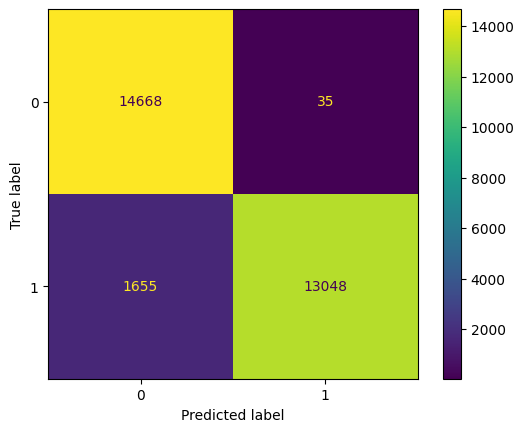

In [243]:
cn_matrix = confusion_matrix(y_true = test_data['class'], 
              y_pred = y_pred_mlflow)

cn_matric_display = ConfusionMatrixDisplay(cn_matrix)
cn_matric_display.plot()

### Voting Classifier

In [225]:
voting_clf = VotingClassifier(estimators=best_estimators_mlflow,
                              n_jobs = -1,
                              verbose = True)
voting_clf

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='log_loss',
                                                     max_features='log2',
                                                     n_estimators=120)),
                             ('Ada_Boost',
                              AdaBoostClassifier(n_estimators=150)),
                             ('Bagging_Classifier',
                              BaggingClassifier(n_estimators=98)),
                             ('Decision_Tree_Classifier',
                              DecisionTreeClassifier(splitter='random')),
                             ('KNN_Classifier',
                              KNeighborsClassifier(weights='distance')),
                             ('Light_GBM',
                              LGBMClassifier(boosting_type='dart',
                                             class_weight='balanced',
                                             learning_rate=0.18130866415578073,
                                             n_estimators=121, n_jobs=-1))],
                 n_jobs=-1, verbose=True)

In [226]:
voting_clf.fit(X = train_data.drop(columns = 'class'),
              y = train_data['class'])

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='log_loss',
                                                     max_features='log2',
                                                     n_estimators=120)),
                             ('Ada_Boost',
                              AdaBoostClassifier(n_estimators=150)),
                             ('Bagging_Classifier',
                              BaggingClassifier(n_estimators=98)),
                             ('Decision_Tree_Classifier',
                              DecisionTreeClassifier(splitter='random')),
                             ('KNN_Classifier',
                              KNeighborsClassifier(weights='distance')),
                             ('Light_GBM',
                              LGBMClassifier(boosting_type='dart',
                                             class_weight='balanced',
                                             learning_rate=0.18130866415578073,
                                             n_estimators=121, n_jobs=-1))],
                 n_jobs=-1, verbose=True)

In [227]:
y_pred_mlflow_voting_clf = voting_clf.predict(X = test_data.drop(columns = 'class'))

In [241]:
metrics_voting_clf = eval_metrics(y_true = test_data['class'], 
              y_pred = y_pred_mlflow_voting_clf)

In [ ]:
metrics_voting_clf

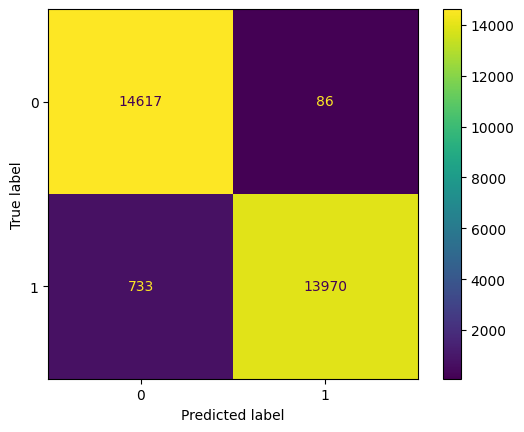

In [229]:
cn_matrix_voting_clf = confusion_matrix(y_true = test_data['class'], 
              y_pred = y_pred_mlflow_voting_clf)

cn_matric_display_voting_clf = ConfusionMatrixDisplay(cn_matrix_voting_clf)
cn_matric_display_voting_clf.plot()

In [248]:
if metrics_stacking_clf['Accuracy_Score'] > metrics_voting_clf['Accuracy_Score']:
    print ("Stacking CLF Wins")

else:
    print ("Voting CLF wins!")

Voting CLF wins!


In [142]:
sample_params

{'boosting_type': 'dart',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.18130866415578073,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 121,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [140]:
client.get_run('cd460708497e4677a2cdcadeaefd8878').data.params

{'boosting_type': 'dart',
 'class_weight': 'balanced',
 'colsample_bytree': '1.0',
 'importance_type': 'split',
 'learning_rate': '0.18130866415578073',
 'max_depth': '-1',
 'min_child_samples': '20',
 'min_child_weight': '0.001',
 'min_split_gain': '0.0',
 'n_estimators': '121',
 'n_jobs': '-1',
 'num_leaves': '31',
 'objective': 'None',
 'random_state': 'None',
 'reg_alpha': '0.0',
 'reg_lambda': '0.0',
 'subsample': '1.0',
 'subsample_for_bin': '200000',
 'subsample_freq': '0'}

In [237]:
np.mean([0.982,0.982,0.9840,0.982,0.9840,0.984,0.98,0.981,0.976,0.981])

0.9816

In [239]:
np.mean([0.981,0.983,0.985,0.983,0.983,0.985,0.981,0.982,0.979,0.981])

0.9822999999999998

In [1]:
import re

In [2]:
original_string = 'SGD_Classifier_Trial_0'

# Using regular expression to remove '_Trial_' followed by any number
result_string = re.sub(r'_Trial_\d+', '', original_string)

result_string

'SGD_Classifier'

In [7]:
import mlflow

mlflow.get_tracking_uri()

'https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow'

In [45]:
parent_runs = mlflow.search_registered_models()
# print("Experiment IDs: ",exp_id)
runs_df = mlflow.search_runs(experiment_ids = list(range(358,371)),
                    search_all_experiments = True,
                    filter_string = f"tags.run_type ilike 'parent'")

In [46]:
runs_df.sort_values(by = 'metrics.Accuracy_Score', ascending=False)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Accuracy_Score,params.n_estimators,params.min_child_samples,params.min_child_weight,...,tags.mlflow.user,tags.mlflow.source.name,tags.tuner,tags.mlflow.runName,tags.trial,tags.run_type,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.model,tags.model_type
9,430820168dbe47159015285ad06ac831,360,FINISHED,mlflow-artifacts:/2f41aed987944507ad6fce5ad822...,2024-01-30 15:55:25.944000+00:00,2024-01-30 16:07:05.726000+00:00,0.988199,150,None,None,...,raj-narayanan-b,f:\iNeuron\Projects\scania_failures_2\scania_t...,optuna,Ada_Boost_Trial_1,1,parent,"[{""run_id"": ""430820168dbe47159015285ad06ac831""...",LOCAL,Ada_Boost,Challenger
10,46c5f82c6eb84ca286593a59d552d5f7,360,FINISHED,mlflow-artifacts:/2f41aed987944507ad6fce5ad822...,2024-01-30 15:44:23.696000+00:00,2024-01-30 15:55:25.562000+00:00,0.987799,139,None,None,...,raj-narayanan-b,f:\iNeuron\Projects\scania_failures_2\scania_t...,optuna,Ada_Boost_Trial_0,0,parent,"[{""run_id"": ""46c5f82c6eb84ca286593a59d552d5f7""...",LOCAL,Ada_Boost,None
8,15bf9b85607d4f549e0242aee3ba1554,360,FINISHED,mlflow-artifacts:/2f41aed987944507ad6fce5ad822...,2024-01-30 16:07:06.160000+00:00,2024-01-30 16:17:57.807000+00:00,0.987599,138,None,None,...,raj-narayanan-b,f:\iNeuron\Projects\scania_failures_2\scania_t...,optuna,Ada_Boost_Trial_2,2,parent,"[{""run_id"": ""15bf9b85607d4f549e0242aee3ba1554""...",LOCAL,Ada_Boost,None
0,cd460708497e4677a2cdcadeaefd8878,370,FINISHED,mlflow-artifacts:/e061ae45350149779d05a0196a81...,2024-01-31 03:00:03.818000+00:00,2024-01-31 03:04:42.986000+00:00,0.987400,121,20,0.001,...,raj-narayanan-b,f:\iNeuron\Projects\scania_failures_2\scania_t...,optuna,Light_GBM_Trial_1,1,parent,"[{""run_id"": ""cd460708497e4677a2cdcadeaefd8878""...",LOCAL,Light_GBM,None
11,8910203da9014861a55037e2f8daec87,359,FINISHED,mlflow-artifacts:/9eac246fb1494777968d745c0a06...,2024-01-30 14:48:40.541000+00:00,2024-01-30 14:53:37.771000+00:00,0.985000,120,None,None,...,raj-narayanan-b,f:\iNeuron\Projects\scania_failures_2\scania_t...,optuna,Random Forest_Trial_1,1,parent,"[{""run_id"": ""8910203da9014861a55037e2f8daec87""...",LOCAL,Random Forest,Challenger
12,051c0457d0fc4c099949bf9a1138eae0,359,FINISHED,mlflow-artifacts:/9eac246fb1494777968d745c0a06...,2024-01-30 14:40:05.588000+00:00,2024-01-30 14:48:40.155000+00:00,0.984400,136,None,None,...,raj-narayanan-b,f:\iNeuron\Projects\scania_failures_2\scania_t...,optuna,Random Forest_Trial_0,0,parent,"[{""run_id"": ""051c0457d0fc4c099949bf9a1138eae0""...",LOCAL,Random Forest,None
7,1f20472871df464e808dcae1c1ff87ad,362,FINISHED,mlflow-artifacts:/04c470f49efb4b4c860192bf5abe...,2024-01-30 18:09:14.586000+00:00,2024-01-30 19:04:56.116000+00:00,0.982600,98,None,None,...,raj-narayanan-b,f:\iNeuron\Projects\scania_failures_2\scania_t...,optuna,Bagging_Classifier_Trial_2,2,parent,"[{""run_id"": ""1f20472871df464e808dcae1c1ff87ad""...",LOCAL,Bagging_Classifier,None
4,d574e78c7c0c420ebf982c91349ff6ab,367,FINISHED,mlflow-artifacts:/45286f1704274a2c97b1a625f6b9...,2024-01-31 02:20:26.016000+00:00,2024-01-31 02:24:25.836000+00:00,0.977600,None,None,None,...,raj-narayanan-b,f:\iNeuron\Projects\scania_failures_2\scania_t...,optuna,Decision_Tree_Classifier_Trial_2,2,parent,"[{""run_id"": ""d574e78c7c0c420ebf982c91349ff6ab""...",LOCAL,Decision_Tree_Classifier,Challenger
6,450efe8500494c1a96b4d1b365adf12d,367,FINISHED,mlflow-artifacts:/45286f1704274a2c97b1a625f6b9...,2024-01-31 02:11:08.852000+00:00,2024-01-31 02:15:52.012000+00:00,0.976600,None,None,None,...,raj-narayanan-b,f:\iNeuron\Projects\scania_failures_2\scania_t...,optuna,Decision_Tree_Classifier_Trial_0,0,parent,"[{""run_id"": ""450efe8500494c1a96b4d1b365adf12d""...",LOCAL,Decision_Tree_Classifier,None
5,cf58145345754406931cdcde472267d7,367,FINISHED,mlflow-artifacts:/45286f1704274a2c97b1a625f6b9...,2024-01-31 02:15:52.541000+00:00,2024-01-31 02:20:25.599000+00:00,0.976600,None,None,None,...,raj-narayanan-b,f:\iNeuron\Projects\scania_fa

In [47]:
parent_runs

[<RegisteredModel: aliases={}, creation_timestamp=1706631479860, description='', last_updated_timestamp=1706631480236, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1706631480236, current_stage='None', description='', last_updated_timestamp=1706631480236, name='Challenger_Ada_Boost', run_id='430820168dbe47159015285ad06ac831', run_link='', source='mlflow-artifacts:/2f41aed987944507ad6fce5ad822d75c/430820168dbe47159015285ad06ac831/artifacts/challenger_Ada_Boost', status='READY', status_message='', tags={}, user_id='', version='1'>], name='Challenger_Ada_Boost', tags={}>,
 <RegisteredModel: aliases={}, creation_timestamp=1706641497818, description='', last_updated_timestamp=1706641498198, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1706641498198, current_stage='None', description='', last_updated_timestamp=1706641498198, name='Challenger_Bagging_Classifier', run_id='1f20472871df464e808dcae1c1ff87ad', run_link='', source='mlflow-artifacts:/04c470f49efb4b

In [48]:
runs_list_ = [parent_runs[i].latest_versions[0].run_id for i in range(len(parent_runs))]
runs_list_

['430820168dbe47159015285ad06ac831',
 '1f20472871df464e808dcae1c1ff87ad',
 'd574e78c7c0c420ebf982c91349ff6ab',
 'e85991c6c1be41b59b3edcb31ac08c61',
 'cd460708497e4677a2cdcadeaefd8878',
 '8910203da9014861a55037e2f8daec87',
 '958b66f62e3d493e89e6998c40c4f5ed']

In [49]:
best_run = runs_df[runs_df['run_id'].isin(runs_list_)].sort_values(by = "metrics.Accuracy_Score", ascending = False).reset_index(drop=True)['run_id'][0]
best_run

'430820168dbe47159015285ad06ac831'

In [33]:
runs_df[runs_df['run_id'] == best_run]['experiment_id'].values[0]

'360'

In [40]:
runs_df[runs_df['run_id'] == best_run].columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.Accuracy_Score', 'params.n_estimators',
       'params.min_child_samples', 'params.min_child_weight',
       'params.min_split_gain', 'params.objective', 'params.subsample_for_bin',
       'params.max_depth', 'params.n_jobs', 'params.importance_type',
       'params.subsample', 'params.learning_rate', 'params.subsample_freq',
       'params.reg_lambda', 'params.class_weight', 'params.random_state',
       'params.reg_alpha', 'params.boosting_type', 'params.colsample_bytree',
       'params.num_leaves', 'params.leaf_size', 'params.metric',
       'params.n_neighbors', 'params.p', 'params.weights',
       'params.metric_params', 'params.algorithm', 'params.max_features',
       'params.ccp_alpha', 'params.max_leaf_nodes', 'params.min_samples_leaf',
       'params.min_impurity_decrease', 'params.splitter', 'params.criterion',
       'params.min_samples_split', 'params.min_weight_fraction_

In [44]:
client.set_tag('8910203da9014861a55037e2f8daec87', "model_type", "Challenger")

In [37]:
client.tracking_uri

'https://dagshub.com/Raj-Narayanan-B/StudentMLProjectRegression.mlflow'

In [56]:
runs_df = mlflow.search_runs(experiment_ids = list(range(358,371)),
                                search_all_experiments = True,
                                filter_string = f"tags.run_type ilike 'parent' and tags.model_type ilike 'Challenger'")

# runs_df = mlflow.search_runs(
#     experiment_ids=list(range(358, 371)),
#     search_all_experiments=True,
#     filter_string="tags.run_type ilike 'parent' and tags.model_type ilike 'Challenger'"
# )

runs_df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Accuracy_Score,params.max_features,params.random_state,params.max_leaf_nodes,...,tags.mlflow.user,tags.mlflow.source.name,tags.tuner,tags.mlflow.runName,tags.trial,tags.model_type,tags.mlflow.log-model.history,tags.run_type,tags.mlflow.source.type,tags.model
0,d574e78c7c0c420ebf982c91349ff6ab,367,FINISHED,mlflow-artifacts:/45286f1704274a2c97b1a625f6b9...,2024-01-31 02:20:26.016000+00:00,2024-01-31 02:24:25.836000+00:00,0.977600,None,None,None,...,raj-narayanan-b,f:\iNeuron\Projects\scania_failures_2\scania_t...,optuna,Decision_Tree_Classifier_Trial_2,2,Challenger,"[{""run_id"": ""d574e78c7c0c420ebf982c91349ff6ab""...",parent,LOCAL,Decision_Tree_Classifier
1,430820168dbe47159015285ad06ac831,360,FINISHED,mlflow-artifacts:/2f41aed987944507ad6fce5ad822...,2024-01-30 15:55:25.944000+00:00,2024-01-30 16:07:05.726000+00:00,0.988199,None,None,None,...,raj-narayanan-b,f:\iNeuron\Projects\scania_failures_2\scania_t...,optuna,Ada_Boost_Trial_1,1,Challenger,"[{""run_id"": ""430820168dbe47159015285ad06ac831""...",parent,LOCAL,Ada_Boost
2,8910203da9014861a55037e2f8daec87,359,FINISHED,mlflow-artifacts:/9eac246fb1494777968d745c0a06...,2024-01-30 14:48:40.541000+00:00,2024-01-30 14:53:37.771000+00:00,0.985000,log2,None,None,...,raj-narayanan-b,f:\iNeuron\Projects\scania_failures_2\scania_t...,optuna,Random Forest_Trial_1,1,Challenger,"[{""run_id"": ""8910203da9014861a55037e2f8daec87""...",parent,LOCAL,Random Forest


In [52]:
runs_df = mlflow.search_runs(
    experiment_ids=list(range(358, 371)),
    search_all_experiments=True,
    filter_string="tags.run_type ilike 'parent' and tags.model_type ilike 'Challenger'"
)


In [53]:
runs_df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Accuracy_Score,params.max_features,params.random_state,params.max_leaf_nodes,...,tags.mlflow.user,tags.mlflow.source.name,tags.tuner,tags.mlflow.runName,tags.trial,tags.model_type,tags.mlflow.log-model.history,tags.run_type,tags.mlflow.source.type,tags.model
0,d574e78c7c0c420ebf982c91349ff6ab,367,FINISHED,mlflow-artifacts:/45286f1704274a2c97b1a625f6b9...,2024-01-31 02:20:26.016000+00:00,2024-01-31 02:24:25.836000+00:00,0.977600,None,None,None,...,raj-narayanan-b,f:\iNeuron\Projects\scania_failures_2\scania_t...,optuna,Decision_Tree_Classifier_Trial_2,2,Challenger,"[{""run_id"": ""d574e78c7c0c420ebf982c91349ff6ab""...",parent,LOCAL,Decision_Tree_Classifier
1,430820168dbe47159015285ad06ac831,360,FINISHED,mlflow-artifacts:/2f41aed987944507ad6fce5ad822...,2024-01-30 15:55:25.944000+00:00,2024-01-30 16:07:05.726000+00:00,0.988199,None,None,None,...,raj-narayanan-b,f:\iNeuron\Projects\scania_failures_2\scania_t...,optuna,Ada_Boost_Trial_1,1,Challenger,"[{""run_id"": ""430820168dbe47159015285ad06ac831""...",parent,LOCAL,Ada_Boost
2,8910203da9014861a55037e2f8daec87,359,FINISHED,mlflow-artifacts:/9eac246fb1494777968d745c0a06...,2024-01-30 14:48:40.541000+00:00,2024-01-30 14:53:37.771000+00:00,0.985000,log2,None,None,...,raj-narayanan-b,f:\iNeuron\Projects\scania_failures_2\scania_t...,optuna,Random Forest_Trial_1,1,Challenger,"[{""run_id"": ""8910203da9014861a55037e2f8daec87""...",parent,LOCAL,Random Forest


In [197]:
train_data.shape

(88332, 171)

In [198]:
train_data['class'].value_counts()

class
0    44166
1    44166
Name: count, dtype: int64

In [199]:
train_data.isna().sum().unique()

array([0], dtype=int64)

In [200]:
test_data.shape

(29406, 171)

In [201]:
test_data['class'].value_counts()

class
0    14703
1    14703
Name: count, dtype: int64

In [202]:
test_data.isna().sum().unique()

array([0], dtype=int64)

In [51]:
stack_clf.fit(X = train_data.drop(columns = 'class'),
              y = train_data['class'])

InvalidParameterError: The 'n_neighbors' parameter of KNeighborsClassifier must be an int in the range [1, inf) or None. Got 5.0 instead.

In [ ]:
sample = [0.4649627097389646, 0.4772051592082544]

max(sample)

In [ ]:
filter_string = f"tags.run_type ilike 'parent'"
mlflow.search_runs(experiment_ids=['725605848744062801'],
                   order_by = ['metrics.Accuracy_Score'],
                   filter_string = filter_string).columns

In [ ]:
client.get_run('ed29462e8f104eb59bf3ecc45883e00f')

In [ ]:
models = {'Logistic_Regression': LogisticRegression, 
                  'SGD_Classifier': SGDClassifier,
                  'Random Forest': RandomForestClassifier, 
                  'Ada_Boost': AdaBoostClassifier, 
                  'Grad_Boost': GradientBoostingClassifier, 
                  'Bagging_Classifier': BaggingClassifier, 
                  'ExtraTreesClassifier': ExtraTreesClassifier, 
                  'Hist_Grad_Boost_Classifier': HistGradientBoostingClassifier, 
                  'Decision_Tree_Classifier': DecisionTreeClassifier,
                  'XGB_Classifier': XGBClassifier,
                  'KNN_Classifier': KNeighborsClassifier,
                  'Stacked_Classifier' : StackingClassifier,
                  'Voting_Classifier' : VotingClassifier
                  }

for key in models.keys():
    try:
        client.delete_registered_model(f"Challenger_{key}")
        client.delete_registered_model(f"Champion {key}")
    except:
        pass

In [ ]:
for i in range(339,341):
    try:
        mlflow.delete_experiment(i)
        print(i)
    except:
        pass

In [ ]:
mlflow.delete_run('67f2092833c349a9ba011fa0d38fbe07')

In [ ]:
rf = RandomForestClassifier(n_estimators=123,
max_features='sqrt',
criterion = 'entropy',
class_weight='balanced_subsample',
n_jobs=-1)
rf

In [ ]:
testing_df = pd.concat([batch_list[10],batch_list[11]])

In [ ]:
training_df = pd.concat([batch_list[i] for i in range(len(batch_list)-2)])

In [ ]:
pipeline_rf = Pipeline(steps = [("KNN_Imputer", KNNImputer()),
                            ("Robust_Scaler", RobustScaler())])
skf_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
smote_ = SMOTETomek(sampling_strategy = "minority",random_state = 42, n_jobs = -1)

x_rf_train = training_df.drop(columns = 'class')
y_rf_train = training_df['class']

x_rf_test = testing_df.drop(columns = 'class')
y_rf_test = testing_df['class']

In [ ]:
print(x_rf_train.shape, y_rf_train.shape)

In [ ]:
print(x_rf_test.shape, y_rf_test.shape)

In [ ]:
print(x_rf_train.isna().sum().unique(),"\n",x_rf_test.isna().sum().unique())

In [ ]:
print(y_rf_train.value_counts(),"\n",y_rf_test.value_counts())

In [ ]:
pipeline_rf

In [ ]:
x_rf_train_transformed = pipeline_rf.fit_transform(x_rf_train)

In [ ]:
pd.DataFrame(x_rf_train_transformed).isna().sum().unique()

In [ ]:
x_rf_train_smote, y_rf_train_smote = smote_.fit_resample(x_rf_train_transformed,y_rf_train)
rf.fit(x_rf_train_smote,y_rf_train_smote)

In [ ]:
x_rf_test_transformed = pipeline_rf.transform(x_rf_test)
x_rf_test_smote, y_rf_test_smote = smote_.fit_resample(x_rf_test_transformed,y_rf_test)

y_rf_pred = rf.predict(x_rf_test_smote)

In [ ]:
eval_metrics(y_true = y_rf_test_smote, y_pred = y_rf_pred)

In [ ]:
import matplotlib.pyplot as plt
tn, fp, fn, tp = confusion_matrix(y_true = y_rf_test_smote, y_pred = y_rf_pred).ravel()
cm = confusion_matrix(y_true = y_rf_test_smote, y_pred = y_rf_pred)
cm_display = ConfusionMatrixDisplay(cm)

cm_display.plot()
plt.show()

In [ ]:
tn, fp, fn, tp

### With Test Data

In [ ]:
test_df_path = Path('D:\\VSCode_Stuff\\updated_scania_truck\\scania_truck\\artifacts\\data\\processed\\stage_1_processing\\preprocessed_test_data.csv')
test_df = pd.read_csv(test_df_path)

In [ ]:
test_df.shape

In [ ]:
test_x = test_df.drop(columns = 'class')
test_y = test_df['class']

In [ ]:
test_x.isna().sum().unique()

In [ ]:
test_y.value_counts()

In [ ]:
test_x_transformed = pipeline_rf.transform(test_x)
test_x_smote,test_y_smote = smote_.fit_resample(test_x_transformed, test_y)
# pipeline_rf = Pipeline(steps = [("KNN_Imputer", KNNImputer()),
#                             ("Robust_Scaler", RobustScaler())])
# skf_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
# smote_ = SMOTETomek(sampling_strategy = "minority",random_state = 42, n_jobs = -1)

In [ ]:
test_y_pred = rf.predict(test_x_smote)

In [ ]:
eval_metrics(y_true = test_y_smote, y_pred = test_y_pred)

In [ ]:
import matplotlib.pyplot as plt
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true = test_y_smote, y_pred = test_y_pred).ravel()
cm_test = confusion_matrix(y_true = test_y_smote, y_pred = test_y_pred)
cm_display_test = ConfusionMatrixDisplay(cm_test)

cm_display_test.plot()
plt.show()

In [ ]:
tn_test, fp_test, fn_test, tp_test

### Checking with LightGBM

In [ ]:
l

In [ ]:
[batch_list[i] for i in range(len(batch_list)-2)]

In [ ]:

accuracy = cross_val_score(estimator=pipeline_rf,
                        X= x_rf_test,
                        y = y_rf_test,
                        scoring = 'accuracy',
                        cv = skf_cv,
                        n_jobs = -1,
                        verbose = 2)

In [ ]:
unpruned_trials = []
for key,value in models.items():
    unpruned_trials.append(model_trial_study_df[key][model_trial_study_df[key]['state'] == "COMPLETE"])

In [ ]:
accuracies == load_yaml(filepath='artifacts/metrics/batch_metrics_optuna.yaml')

In [ ]:
pd.DataFrame(accuracies).to_csv("artifacts\metrics\\batch_metrics_df\\batch_metrics_optuna.csv")

In [ ]:
save_yaml(file = accuracies, filepath='artifacts/metrics/batch_metrics_optuna.yaml')

In [ ]:
model_trial_study_df

In [ ]:
for key in models.keys():
    model_trial_study_df[key].to_csv(f"artifacts\metrics\\batch_metrics_df\{key}.csv",index=False)

In [ ]:
find_params.trials_dataframe()

In [ ]:
pprint(accuracies,compact=True)

In [ ]:
np.median(accuracies['Logistic_Regression']['Optuna'][:5])

In [ ]:
accuracies['Logistic_Regression']['Optuna'][:6]

In [ ]:
find_params.user_attrs

In [ ]:
find_params.trials_dataframe()

In [ ]:
np.mean(accuracies['Logistic_Regression']['Optuna'][:24])

In [ ]:
np.mean(accuracies['Logistic_Regression']['Optuna'])

In [ ]:
np.mean(list(set(accuracies['Logistic_Regression']['Optuna'])))

In [ ]:
# find_params = optuna.create_study(direction = 'maximize')
# find_params.optimize(func = optuna_objective,
#                      n_trials = 5)
#                     #  n_jobs = -1)

In [ ]:
space = {
    'n_estimators': optuna.distributions.IntDistribution(100, 150),
    'criterion' : optuna.distributions.CategoricalDistribution(['log_loss', 'entropy', 'gini']),
    'max_features' : optuna.distributions.CategoricalDistribution(['sqrt', 'log2', None]),
    'class_weight' : optuna.distributions.CategoricalDistribution(['balanced', 'balanced_subsample'])
    }

pipeline = Pipeline(steps = [("KNN_Imputer", KNNImputer()),
                                    ("Robust_Scaler", RobustScaler()),
                                    ("SMOTETomek", SMOTETomek(sampling_strategy = "minority",random_state = 42, n_jobs = -1)),
                                    (f"Random Forest", RandomForestClassifier(n_jobs=-1).set_params(**space))])
skf_cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# optuna_search = optuna.integration.OptunaSearchCV(estimator = pipeline,
#                                   param_distributions = {'verbose':optuna.distributions.CategoricalDistribution([True,False])},
#                                   cv = skf_cv,
#                                   n_jobs = -1,
#                                   n_trials = 10,
#                                   random_state = 42,
#                                   refit = True,
#                                   return_train_score = False,
#                                   scoring = 'accuracy',
#                                   verbose = 3)

In [ ]:
pipeline

In [ ]:
x = batch_list[2].drop(columns='class')
y = batch_list[2]['class']
optuna_search.fit(x,y)